In [54]:
from WBT.whitebox_tools import WhiteboxTools
import rasterio
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
import math

wbt = WhiteboxTools()

In [25]:
os.chdir(r'C:\\Users\\sasha\\abstract_surfaces\\')

In [26]:
entries = os.listdir('./surfaces/')
entries

['clear', 'noisy']

In [28]:
clear_dems = os.listdir('./surfaces/' + entries[0])
noisy_dems = os.listdir('./surfaces/' + entries[1])

print(f'Clear dems: {clear_dems}', f'Noisy dems: {noisy_dems}', sep='\n')

Clear dems: ['hemicylinder_clear.tif', 'hemisphere_clear.tif', 'inclined_clear.tif', 'inclined_surface_clear.tif', 'paraboloid_clear.tif']
Noisy dems: ['hemicylinder_n_05.tif', 'hemicylinder_n_1.tif', 'hemicylinder_n_2.tif', 'hemisphere_n_05.tif', 'hemisphere_n_1.tif', 'hemisphere_n_2.tif', 'inclined_n_05.tif', 'inclined_n_1.tif', 'inclined_n_2.tif', 'paraboloid_n_05.tif', 'paraboloid_n_1.tif', 'paraboloid_n_2.tif']


In [29]:
arr_clear_dems = []
for clear_dem in clear_dems:
    
    tmp_path = r'C:\Users\sasha\abstract_surfaces\surfaces\clear\\' + clear_dem
    #print(tmp_path)
    
    with rasterio.open(tmp_path, 'r') as ds:
        arr_in = ds.read()
    #arr_clear_dems[clear_dem] = arr_in[0]
    arr_clear_dems.append(arr_in[0])
    #plt.imshow(arr_noisy_dems[-1], cmap='binary')
    #plt.show()
    print(f'Appended {clear_dem}')

Appended hemicylinder_clear.tif
Appended hemisphere_clear.tif
Appended inclined_clear.tif
Appended inclined_surface_clear.tif
Appended paraboloid_clear.tif


In [30]:
arr_noisy_dems = []
for noisy_dem in noisy_dems:
    
    tmp_path = r'C:\Users\sasha\abstract_surfaces\surfaces\noisy\\' + noisy_dem
    #print(tmp_path)
    
    with rasterio.open(tmp_path, 'r') as ds:
        arr_in = ds.read()
    #arr_noisy_dems[noisy_dem] = arr_in[0]
    arr_noisy_dems.append(arr_in[0])
    #plt.imshow(arr_noisy_dems[-1], cmap='binary')
    #plt.show()
    print(f'Appended {noisy_dem}')

Appended hemicylinder_n_05.tif
Appended hemicylinder_n_1.tif
Appended hemicylinder_n_2.tif
Appended hemisphere_n_05.tif
Appended hemisphere_n_1.tif
Appended hemisphere_n_2.tif
Appended inclined_n_05.tif
Appended inclined_n_1.tif
Appended inclined_n_2.tif
Appended paraboloid_n_05.tif
Appended paraboloid_n_1.tif
Appended paraboloid_n_2.tif


In [13]:
#len(arr_noisy_dems)

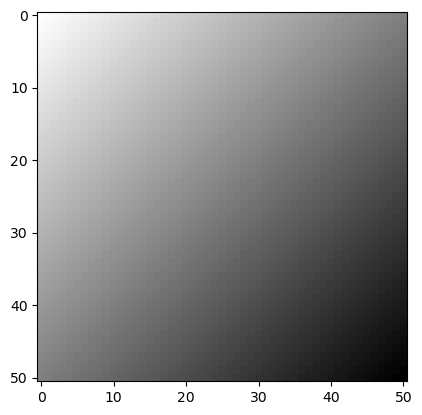

In [39]:
clear_path = r'C:\Users\sasha\abstract_surfaces\surfaces\clear\\' + noisy_dems[7].split('_')[0] + '_clear.tif'
    
with rasterio.open(clear_path, 'r') as ds:
    data_clear = ds.read()
    data_clear = data_clear[0]
        
plt.imshow(data_clear, cmap='binary')
plt.show()

In [48]:
dd = {'asa' : 1}
print(dd)
dd.update({'asa': 2})
print(dd)

{'asa': 1}
{'asa': 2}


In [67]:
arr_filtered_dems = []
best_filter = {}
for noisy_dem in noisy_dems:
    
    clear_path = r'C:\Users\sasha\abstract_surfaces\surfaces\clear\\' + noisy_dem.split('_')[0] + '_clear.tif'
    tmp_path = r'C:\Users\sasha\abstract_surfaces\surfaces\noisy\\' + noisy_dem
    output_path = r'C:\Users\sasha\abstract_surfaces\surfaces\current_' + noisy_dem.split('_')[0] + '.tif'
    #good_path = r'C:\Users\sasha\abstract_surfaces\surfaces\best_' + noisy_dem.split('_')[0] + '.tif'
    
    with rasterio.open(clear_path, 'r') as ds:
        data_clear = ds.read()
        data_clear = data_clear[0] 
        
    with rasterio.open(tmp_path, 'r') as ds:
        data_noisy = ds.read()
        data_noisy = data_noisy[0]    
    
    min_mean = 99999
    
    wbt.verbose = True
    
    # - - -
    #MeanFilter
    wbt.mean_filter(
        i = tmp_path, 
        output = output_path, 
        filterx=5, 
        filtery=5
    )
    
    with rasterio.open(output_path, 'r') as ds:
        data_filt = ds.read()
        data_filt = data_clear[0]
    
    if np.mean(np.subtract(data_clear, data_filt)) < min_mean:
        print("Ladies and Gentlemen we got him")
        best_filter.update({noisy_dem : ['MeanFilter', 5, 5]})
        min_mean = np.mean(np.subtract(data_clear, data_filt))
    
    # - - -
    #MedianFilter
    wbt.median_filter(
        i = tmp_path, 
        output = output_path, 
        filterx=5, 
        filtery=5,
        sig_digits=2
    )
    
    with rasterio.open(output_path, 'r') as ds:
        data_filt = ds.read()
        data_filt = data_clear[0]
    
    if np.mean(np.subtract(data_clear, data_filt)) < min_mean:
        print("Ladies and Gentlemen we got him")
        best_filter.update({noisy_dem : ['MedianFilter', 5, 5]})
        min_mean = np.mean(np.subtract(data_clear, data_filt))
    
    # - - -
    #AdaptiveFilter
    for threshold in np.arange(0.1, 2.1, 0.1):
        threshold = round(threshold, 2)
        wbt.adaptive_filter(
            i = tmp_path, 
            output = output_path, 
            filterx=5, 
            filtery=5, 
            threshold=threshold
        )
        
        with rasterio.open(output_path, 'r') as ds:
            data_filt = ds.read()
            data_filt = data_clear[0]

        if np.mean(np.subtract(data_clear, data_filt)) < min_mean:
            print("Ladies and Gentlemen we got him")
            best_filter.update({noisy_dem : ['AdaptiveFilter', 5, 5, threshold]})
            min_mean = np.mean(np.subtract(data_clear, data_filt))
        
    # - - -
    #OlympicFilter
    wbt.olympic_filter(
        i=tmp_path, 
        output=output_path, 
        filterx=5, 
        filtery=5
    )
    
    with rasterio.open(output_path, 'r') as ds:
        data_filt = ds.read()
        data_filt = data_clear[0]
    
    if np.mean(np.subtract(data_clear, data_filt)) < min_mean:
        print("Ladies and Gentlemen we got him")
        best_filter.update({noisy_dem : ['OlympicFilter', 5, 5]})
        min_mean = np.mean(np.subtract(data_clear, data_filt))
    
        
best_filter

.\whitebox_tools.exe --run="MeanFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\hemicylinder_n_05.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_hemicylinder.tif' --filterx=5 --filtery=5 -v --compress_rasters=False

****************************
* Welcome to MeanFilter    *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Creating integral images: 0%
Creating integral images: 1%
Creating integral images: 2%
Creating integral images: 3%
Creating integral images: 4%
Creating integral images: 5%
Creating integral images: 6%
Creating integral images: 7%
Creating integral images: 8%
Creating integral images: 10%
Creating integral images: 11%
Creating integral images: 12%
Creating integral images: 13%
Creating integral images: 14%
Creating integral images: 15%
Creating integral images: 16%
Creating integral images: 17%
Creating integral images: 19%
Creating integral images: 20%
Creating integra

Performing analysis: 76%
Performing analysis: 77%
Performing analysis: 78%
Performing analysis: 79%
Performing analysis: 80%
Performing analysis: 82%
Performing analysis: 83%
Performing analysis: 84%
Performing analysis: 85%
Performing analysis: 86%
Performing analysis: 87%
Performing analysis: 88%
Performing analysis: 89%
Performing analysis: 91%
Performing analysis: 92%
Performing analysis: 93%
Performing analysis: 94%
Performing analysis: 95%
Performing analysis: 96%
Performing analysis: 97%
Performing analysis: 98%
Performing analysis: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.5s
.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\hemicylinder_n_05.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_hemicylinder.tif' --filterx=5 --filtery=5 --threshold=0.1 -v --compress_rasters=False

*****************************
* Welcome to AdaptiveFilter *
* Powered by WhiteboxTools  *
* www.w

Calculating integral images: 82%
Calculating integral images: 83%
Calculating integral images: 84%
Calculating integral images: 85%
Calculating integral images: 86%
Calculating integral images: 87%
Calculating integral images: 88%
Calculating integral images: 89%
Calculating integral images: 91%
Calculating integral images: 92%
Calculating integral images: 93%
Calculating integral images: 94%
Calculating integral images: 95%
Calculating integral images: 96%
Calculating integral images: 97%
Calculating integral images: 98%
Calculating integral images: 100%
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%

Calculating integral images: 39%
Calculating integral images: 40%
Calculating integral images: 41%
Calculating integral images: 42%
Calculating integral images: 43%
Calculating integral images: 44%
Calculating integral images: 46%
Calculating integral images: 47%
Calculating integral images: 48%
Calculating integral images: 49%
Calculating integral images: 50%
Calculating integral images: 51%
Calculating integral images: 52%
Calculating integral images: 53%
Calculating integral images: 55%
Calculating integral images: 56%
Calculating integral images: 57%
Calculating integral images: 58%
Calculating integral images: 59%
Calculating integral images: 60%
Calculating integral images: 61%
Calculating integral images: 62%
Calculating integral images: 64%
Calculating integral images: 65%
Calculating integral images: 66%
Calculating integral images: 67%
Calculating integral images: 68%
Calculating integral images: 69%
Calculating integral images: 70%
Calculating integral images: 71%
Calculatin

* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Calculating integral images: 0%
Calculating integral images: 1%
Calculating integral images: 2%
Calculating integral images: 3%
Calculating integral images: 4%
Calculating integral images: 5%
Calculating integral images: 6%
Calculating integral images: 7%
Calculating integral images: 8%
Calculating integral images: 10%
Calculating integral images: 11%
Calculating integral images: 12%
Calculating integral images: 13%
Calculating integral images: 14%
Calculating integral images: 15%
Calculating integral images: 16%
Calculating integral images: 17%
Calculating integral images: 19%
Calculating integral images: 20%
Calculating integral images: 21%
Calculating integral images: 22%
Calculating integral images: 23%
Calculating integral images: 24%
Calculating integral images: 25%
Calculating integral images: 26%
Calculating integral images: 28%
Calculating integral images: 29%
Calculating 

Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Progress: 60%
Progress: 61%
Progress: 62%
Progress: 64%
Progress: 65%
Progress: 66%
Progress: 67%
Progress: 68%
Progress: 69%
Progress: 70%
Progress: 71%
Progress: 73%
Progress: 74%
Progress: 75%
Progress: 76%
Progress: 77%
Progress: 78%
Progress: 79%
Progress: 80%
Progress: 82%
Progress: 83%
Progress: 84%
Progress: 85%
Progress: 86%
Progress: 87%
Progress: 88%
Progress: 89%
Progress: 91%
Progress: 92%
Progress: 93%
Progress: 94%
Progress: 95%
Progress: 96%
Progress: 97%
Progress: 98%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.3s
.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sas

Calculating integral images: 71%
Calculating integral images: 73%
Calculating integral images: 74%
Calculating integral images: 75%
Calculating integral images: 76%
Calculating integral images: 77%
Calculating integral images: 78%
Calculating integral images: 79%
Calculating integral images: 80%
Calculating integral images: 82%
Calculating integral images: 83%
Calculating integral images: 84%
Calculating integral images: 85%
Calculating integral images: 86%
Calculating integral images: 87%
Calculating integral images: 88%
Calculating integral images: 89%
Calculating integral images: 91%
Calculating integral images: 92%
Calculating integral images: 93%
Calculating integral images: 94%
Calculating integral images: 95%
Calculating integral images: 96%
Calculating integral images: 97%
Calculating integral images: 98%
Calculating integral images: 100%
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 10%
Progress: 

Calculating integral images: 29%
Calculating integral images: 30%
Calculating integral images: 31%
Calculating integral images: 32%
Calculating integral images: 33%
Calculating integral images: 34%
Calculating integral images: 35%
Calculating integral images: 37%
Calculating integral images: 38%
Calculating integral images: 39%
Calculating integral images: 40%
Calculating integral images: 41%
Calculating integral images: 42%
Calculating integral images: 43%
Calculating integral images: 44%
Calculating integral images: 46%
Calculating integral images: 47%
Calculating integral images: 48%
Calculating integral images: 49%
Calculating integral images: 50%
Calculating integral images: 51%
Calculating integral images: 52%
Calculating integral images: 53%
Calculating integral images: 55%
Calculating integral images: 56%
Calculating integral images: 57%
Calculating integral images: 58%
Calculating integral images: 59%
Calculating integral images: 60%
Calculating integral images: 61%
Calculatin

*****************************
* Welcome to AdaptiveFilter *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Calculating integral images: 0%
Calculating integral images: 1%
Calculating integral images: 2%
Calculating integral images: 3%
Calculating integral images: 4%
Calculating integral images: 5%
Calculating integral images: 6%
Calculating integral images: 7%
Calculating integral images: 8%
Calculating integral images: 10%
Calculating integral images: 11%
Calculating integral images: 12%
Calculating integral images: 13%
Calculating integral images: 14%
Calculating integral images: 15%
Calculating integral images: 16%
Calculating integral images: 17%
Calculating integral images: 19%
Calculating integral images: 20%
Calculating integral images: 21%
Calculating integral images: 22%
Calculating integral images: 23%
Calculating integral images: 24%
Calculating integral images: 25%
Calculating integral images: 26%
Calculating integr

Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Progress: 60%
Progress: 61%
Progress: 62%
Progress: 64%
Progress: 65%
Progress: 66%
Progress: 67%
Progress: 68%
Progress: 69%
Progress: 70%
Progress: 71%
Progress: 73%
Progress: 74%
Progress: 75%
Progress: 76%
Progress: 77%
Progress: 78%
Progress: 79%
Progress: 80%
Progress: 82%
Progress: 83%
Progress: 84%
Progress: 85%
Progress: 86%
Progress: 87%
Progress: 88%
Progress: 89%
Progress: 91%
Progress: 92%
Progress: 93%
Progress: 94%
Progress: 95%
Progress: 96%
Progress: 97%
Progress: 98%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.3s
.\whitebox_tools.ex

Calculating integral images: 69%
Calculating integral images: 70%
Calculating integral images: 71%
Calculating integral images: 73%
Calculating integral images: 74%
Calculating integral images: 75%
Calculating integral images: 76%
Calculating integral images: 77%
Calculating integral images: 78%
Calculating integral images: 79%
Calculating integral images: 80%
Calculating integral images: 82%
Calculating integral images: 83%
Calculating integral images: 84%
Calculating integral images: 85%
Calculating integral images: 86%
Calculating integral images: 87%
Calculating integral images: 88%
Calculating integral images: 89%
Calculating integral images: 91%
Calculating integral images: 92%
Calculating integral images: 93%
Calculating integral images: 94%
Calculating integral images: 95%
Calculating integral images: 96%
Calculating integral images: 97%
Calculating integral images: 98%
Calculating integral images: 100%
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 

Calculating integral images: 26%
Calculating integral images: 28%
Calculating integral images: 29%
Calculating integral images: 30%
Calculating integral images: 31%
Calculating integral images: 32%
Calculating integral images: 33%
Calculating integral images: 34%
Calculating integral images: 35%
Calculating integral images: 37%
Calculating integral images: 38%
Calculating integral images: 39%
Calculating integral images: 40%
Calculating integral images: 41%
Calculating integral images: 42%
Calculating integral images: 43%
Calculating integral images: 44%
Calculating integral images: 46%
Calculating integral images: 47%
Calculating integral images: 48%
Calculating integral images: 49%
Calculating integral images: 50%
Calculating integral images: 51%
Calculating integral images: 52%
Calculating integral images: 53%
Calculating integral images: 55%
Calculating integral images: 56%
Calculating integral images: 57%
Calculating integral images: 58%
Calculating integral images: 59%
Calculatin

Elapsed Time (excluding I/O): 0.3s
.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\hemicylinder_n_05.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_hemicylinder.tif' --filterx=5 --filtery=5 --threshold=2.0 -v --compress_rasters=False

*****************************
* Welcome to AdaptiveFilter *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Calculating integral images: 0%
Calculating integral images: 1%
Calculating integral images: 2%
Calculating integral images: 3%
Calculating integral images: 4%
Calculating integral images: 5%
Calculating integral images: 6%
Calculating integral images: 7%
Calculating integral images: 8%
Calculating integral images: 10%
Calculating integral images: 11%
Calculating integral images: 12%
Calculating integral images: 13%
Calculating integral images: 14%
Calculating integral images: 15%
Calculating integral images: 16

Creating integral images: 48%
Creating integral images: 49%
Creating integral images: 50%
Creating integral images: 51%
Creating integral images: 52%
Creating integral images: 53%
Creating integral images: 55%
Creating integral images: 56%
Creating integral images: 57%
Creating integral images: 58%
Creating integral images: 59%
Creating integral images: 60%
Creating integral images: 61%
Creating integral images: 62%
Creating integral images: 64%
Creating integral images: 65%
Creating integral images: 66%
Creating integral images: 67%
Creating integral images: 68%
Creating integral images: 69%
Creating integral images: 70%
Creating integral images: 71%
Creating integral images: 73%
Creating integral images: 74%
Creating integral images: 75%
Creating integral images: 76%
Creating integral images: 77%
Creating integral images: 78%
Creating integral images: 79%
Creating integral images: 80%
Creating integral images: 82%
Creating integral images: 83%
Creating integral images: 84%
Creating i

Calculating integral images: 21%
Calculating integral images: 22%
Calculating integral images: 23%
Calculating integral images: 24%
Calculating integral images: 25%
Calculating integral images: 26%
Calculating integral images: 28%
Calculating integral images: 29%
Calculating integral images: 30%
Calculating integral images: 31%
Calculating integral images: 32%
Calculating integral images: 33%
Calculating integral images: 34%
Calculating integral images: 35%
Calculating integral images: 37%
Calculating integral images: 38%
Calculating integral images: 39%
Calculating integral images: 40%
Calculating integral images: 41%
Calculating integral images: 42%
Calculating integral images: 43%
Calculating integral images: 44%
Calculating integral images: 46%
Calculating integral images: 47%
Calculating integral images: 48%
Calculating integral images: 49%
Calculating integral images: 50%
Calculating integral images: 51%
Calculating integral images: 52%
Calculating integral images: 53%
Calculatin

Progress: 91%
Progress: 92%
Progress: 93%
Progress: 94%
Progress: 95%
Progress: 96%
Progress: 97%
Progress: 98%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.2s
.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\hemicylinder_n_1.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_hemicylinder.tif' --filterx=5 --filtery=5 --threshold=0.3 -v --compress_rasters=False

*****************************
* Welcome to AdaptiveFilter *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Calculating integral images: 0%
Calculating integral images: 1%
Calculating integral images: 2%
Calculating integral images: 3%
Calculating integral images: 4%
Calculating integral images: 5%
Calculating integral images: 6%
Calculating integral images: 7%
Calculating integral images: 8%
Calculating integral images: 10%
Calculating integral images: 11%
Ca

Calculating integral images: 96%
Calculating integral images: 97%
Calculating integral images: 98%
Calculating integral images: 100%
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Progress: 60%
Progress: 61%
Progress: 62%
Progress: 64%
Progress: 65%
Progress: 66%
Progress: 67%
Progress: 68%
Progress

Calculating integral images: 53%
Calculating integral images: 55%
Calculating integral images: 56%
Calculating integral images: 57%
Calculating integral images: 58%
Calculating integral images: 59%
Calculating integral images: 60%
Calculating integral images: 61%
Calculating integral images: 62%
Calculating integral images: 64%
Calculating integral images: 65%
Calculating integral images: 66%
Calculating integral images: 67%
Calculating integral images: 68%
Calculating integral images: 69%
Calculating integral images: 70%
Calculating integral images: 71%
Calculating integral images: 73%
Calculating integral images: 74%
Calculating integral images: 75%
Calculating integral images: 76%
Calculating integral images: 77%
Calculating integral images: 78%
Calculating integral images: 79%
Calculating integral images: 80%
Calculating integral images: 82%
Calculating integral images: 83%
Calculating integral images: 84%
Calculating integral images: 85%
Calculating integral images: 86%
Calculatin

Calculating integral images: 11%
Calculating integral images: 12%
Calculating integral images: 13%
Calculating integral images: 14%
Calculating integral images: 15%
Calculating integral images: 16%
Calculating integral images: 17%
Calculating integral images: 19%
Calculating integral images: 20%
Calculating integral images: 21%
Calculating integral images: 22%
Calculating integral images: 23%
Calculating integral images: 24%
Calculating integral images: 25%
Calculating integral images: 26%
Calculating integral images: 28%
Calculating integral images: 29%
Calculating integral images: 30%
Calculating integral images: 31%
Calculating integral images: 32%
Calculating integral images: 33%
Calculating integral images: 34%
Calculating integral images: 35%
Calculating integral images: 37%
Calculating integral images: 38%
Calculating integral images: 39%
Calculating integral images: 40%
Calculating integral images: 41%
Calculating integral images: 42%
Calculating integral images: 43%
Calculatin

Progress: 67%
Progress: 68%
Progress: 69%
Progress: 70%
Progress: 71%
Progress: 73%
Progress: 74%
Progress: 75%
Progress: 76%
Progress: 77%
Progress: 78%
Progress: 79%
Progress: 80%
Progress: 82%
Progress: 83%
Progress: 84%
Progress: 85%
Progress: 86%
Progress: 87%
Progress: 88%
Progress: 89%
Progress: 91%
Progress: 92%
Progress: 93%
Progress: 94%
Progress: 95%
Progress: 96%
Progress: 97%
Progress: 98%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.4s
.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\hemicylinder_n_1.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_hemicylinder.tif' --filterx=5 --filtery=5 --threshold=1.0 -v --compress_rasters=False

*****************************
* Welcome to AdaptiveFilter *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Calculating integral images: 0%
Calculating integral images: 1

Calculating integral images: 86%
Calculating integral images: 87%
Calculating integral images: 88%
Calculating integral images: 89%
Calculating integral images: 91%
Calculating integral images: 92%
Calculating integral images: 93%
Calculating integral images: 94%
Calculating integral images: 95%
Calculating integral images: 96%
Calculating integral images: 97%
Calculating integral images: 98%
Calculating integral images: 100%
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progr

Calculating integral images: 43%
Calculating integral images: 44%
Calculating integral images: 46%
Calculating integral images: 47%
Calculating integral images: 48%
Calculating integral images: 49%
Calculating integral images: 50%
Calculating integral images: 51%
Calculating integral images: 52%
Calculating integral images: 53%
Calculating integral images: 55%
Calculating integral images: 56%
Calculating integral images: 57%
Calculating integral images: 58%
Calculating integral images: 59%
Calculating integral images: 60%
Calculating integral images: 61%
Calculating integral images: 62%
Calculating integral images: 64%
Calculating integral images: 65%
Calculating integral images: 66%
Calculating integral images: 67%
Calculating integral images: 68%
Calculating integral images: 69%
Calculating integral images: 70%
Calculating integral images: 71%
Calculating integral images: 73%
Calculating integral images: 74%
Calculating integral images: 75%
Calculating integral images: 76%
Calculatin

Calculating integral images: 1%
Calculating integral images: 2%
Calculating integral images: 3%
Calculating integral images: 4%
Calculating integral images: 5%
Calculating integral images: 6%
Calculating integral images: 7%
Calculating integral images: 8%
Calculating integral images: 10%
Calculating integral images: 11%
Calculating integral images: 12%
Calculating integral images: 13%
Calculating integral images: 14%
Calculating integral images: 15%
Calculating integral images: 16%
Calculating integral images: 17%
Calculating integral images: 19%
Calculating integral images: 20%
Calculating integral images: 21%
Calculating integral images: 22%
Calculating integral images: 23%
Calculating integral images: 24%
Calculating integral images: 25%
Calculating integral images: 26%
Calculating integral images: 28%
Calculating integral images: 29%
Calculating integral images: 30%
Calculating integral images: 31%
Calculating integral images: 32%
Calculating integral images: 33%
Calculating integr

Progress: 43%
Progress: 44%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Progress: 60%
Progress: 61%
Progress: 62%
Progress: 64%
Progress: 65%
Progress: 66%
Progress: 67%
Progress: 68%
Progress: 69%
Progress: 70%
Progress: 71%
Progress: 73%
Progress: 74%
Progress: 75%
Progress: 76%
Progress: 77%
Progress: 78%
Progress: 79%
Progress: 80%
Progress: 82%
Progress: 83%
Progress: 84%
Progress: 85%
Progress: 86%
Progress: 87%
Progress: 88%
Progress: 89%
Progress: 91%
Progress: 92%
Progress: 93%
Progress: 94%
Progress: 95%
Progress: 96%
Progress: 97%
Progress: 98%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.2s
.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\hemicylinder_n_1.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_hemicylinder.tif' --f

Calculating integral images: 76%
Calculating integral images: 77%
Calculating integral images: 78%
Calculating integral images: 79%
Calculating integral images: 80%
Calculating integral images: 82%
Calculating integral images: 83%
Calculating integral images: 84%
Calculating integral images: 85%
Calculating integral images: 86%
Calculating integral images: 87%
Calculating integral images: 88%
Calculating integral images: 89%
Calculating integral images: 91%
Calculating integral images: 92%
Calculating integral images: 93%
Calculating integral images: 94%
Calculating integral images: 95%
Calculating integral images: 96%
Calculating integral images: 97%
Calculating integral images: 98%
Calculating integral images: 100%
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 19%
Progress: 20%
Progress: 21%
Pr

Calculating integral images: 33%
Calculating integral images: 34%
Calculating integral images: 35%
Calculating integral images: 37%
Calculating integral images: 38%
Calculating integral images: 39%
Calculating integral images: 40%
Calculating integral images: 41%
Calculating integral images: 42%
Calculating integral images: 43%
Calculating integral images: 44%
Calculating integral images: 46%
Calculating integral images: 47%
Calculating integral images: 48%
Calculating integral images: 49%
Calculating integral images: 50%
Calculating integral images: 51%
Calculating integral images: 52%
Calculating integral images: 53%
Calculating integral images: 55%
Calculating integral images: 56%
Calculating integral images: 57%
Calculating integral images: 58%
Calculating integral images: 59%
Calculating integral images: 60%
Calculating integral images: 61%
Calculating integral images: 62%
Calculating integral images: 64%
Calculating integral images: 65%
Calculating integral images: 66%
Calculatin

Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Progress: 60%
Progress: 61%
Progress: 62%
Progress: 64%
Progress: 65%
Progress: 66%
Progress: 67%
Progress: 68%
Progress: 69%
Progress: 70%
Progress: 71%
Progress: 73%
Progress: 74%
Progress: 75%
Progress: 76%
Progress: 77%
Progress: 78%
Progress: 79%
Progress: 80%
Progress: 82%
Progress: 83

Calculating integral images: 70%
Calculating integral images: 71%
Calculating integral images: 73%
Calculating integral images: 74%
Calculating integral images: 75%
Calculating integral images: 76%
Calculating integral images: 77%
Calculating integral images: 78%
Calculating integral images: 79%
Calculating integral images: 80%
Calculating integral images: 82%
Calculating integral images: 83%
Calculating integral images: 84%
Calculating integral images: 85%
Calculating integral images: 86%
Calculating integral images: 87%
Calculating integral images: 88%
Calculating integral images: 89%
Calculating integral images: 91%
Calculating integral images: 92%
Calculating integral images: 93%
Calculating integral images: 94%
Calculating integral images: 95%
Calculating integral images: 96%
Calculating integral images: 97%
Calculating integral images: 98%
Calculating integral images: 100%
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Prog

Calculating integral images: 28%
Calculating integral images: 29%
Calculating integral images: 30%
Calculating integral images: 31%
Calculating integral images: 32%
Calculating integral images: 33%
Calculating integral images: 34%
Calculating integral images: 35%
Calculating integral images: 37%
Calculating integral images: 38%
Calculating integral images: 39%
Calculating integral images: 40%
Calculating integral images: 41%
Calculating integral images: 42%
Calculating integral images: 43%
Calculating integral images: 44%
Calculating integral images: 46%
Calculating integral images: 47%
Calculating integral images: 48%
Calculating integral images: 49%
Calculating integral images: 50%
Calculating integral images: 51%
Calculating integral images: 52%
Calculating integral images: 53%
Calculating integral images: 55%
Calculating integral images: 56%
Calculating integral images: 57%
Calculating integral images: 58%
Calculating integral images: 59%
Calculating integral images: 60%
Calculatin

.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\hemicylinder_n_2.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_hemicylinder.tif' --filterx=5 --filtery=5 --threshold=0.5 -v --compress_rasters=False

*****************************
* Welcome to AdaptiveFilter *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Calculating integral images: 0%
Calculating integral images: 1%
Calculating integral images: 2%
Calculating integral images: 3%
Calculating integral images: 4%
Calculating integral images: 5%
Calculating integral images: 6%
Calculating integral images: 7%
Calculating integral images: 8%
Calculating integral images: 10%
Calculating integral images: 11%
Calculating integral images: 12%
Calculating integral images: 13%
Calculating integral images: 14%
Calculating integral images: 15%
Calculating integral images: 16%
Calculating integral images: 17%
C

Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Progress: 60%
Progress: 61%
Progress: 62%
Progress: 64%
Progress: 65%
Progress: 66%
Progress: 67%
Progress: 68%
Progress: 69%
Progress: 70%
Progress: 71%
Progress: 73%
Progress: 74%
Progress: 75%
Progress: 76%
Progress: 77%
Progress: 78%
Progress: 79%
Progress: 80%
Progress: 82%
Progress: 83%
Progress: 84%
Progress: 

Calculating integral images: 60%
Calculating integral images: 61%
Calculating integral images: 62%
Calculating integral images: 64%
Calculating integral images: 65%
Calculating integral images: 66%
Calculating integral images: 67%
Calculating integral images: 68%
Calculating integral images: 69%
Calculating integral images: 70%
Calculating integral images: 71%
Calculating integral images: 73%
Calculating integral images: 74%
Calculating integral images: 75%
Calculating integral images: 76%
Calculating integral images: 77%
Calculating integral images: 78%
Calculating integral images: 79%
Calculating integral images: 80%
Calculating integral images: 82%
Calculating integral images: 83%
Calculating integral images: 84%
Calculating integral images: 85%
Calculating integral images: 86%
Calculating integral images: 87%
Calculating integral images: 88%
Calculating integral images: 89%
Calculating integral images: 91%
Calculating integral images: 92%
Calculating integral images: 93%
Calculatin

Calculating integral images: 17%
Calculating integral images: 19%
Calculating integral images: 20%
Calculating integral images: 21%
Calculating integral images: 22%
Calculating integral images: 23%
Calculating integral images: 24%
Calculating integral images: 25%
Calculating integral images: 26%
Calculating integral images: 28%
Calculating integral images: 29%
Calculating integral images: 30%
Calculating integral images: 31%
Calculating integral images: 32%
Calculating integral images: 33%
Calculating integral images: 34%
Calculating integral images: 35%
Calculating integral images: 37%
Calculating integral images: 38%
Calculating integral images: 39%
Calculating integral images: 40%
Calculating integral images: 41%
Calculating integral images: 42%
Calculating integral images: 43%
Calculating integral images: 44%
Calculating integral images: 46%
Calculating integral images: 47%
Calculating integral images: 48%
Calculating integral images: 49%
Calculating integral images: 50%
Calculatin

Progress: 83%
Progress: 84%
Progress: 85%
Progress: 86%
Progress: 87%
Progress: 88%
Progress: 89%
Progress: 91%
Progress: 92%
Progress: 93%
Progress: 94%
Progress: 95%
Progress: 96%
Progress: 97%
Progress: 98%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.3s
.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\hemicylinder_n_2.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_hemicylinder.tif' --filterx=5 --filtery=5 --threshold=1.2 -v --compress_rasters=False

*****************************
* Welcome to AdaptiveFilter *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Calculating integral images: 0%
Calculating integral images: 1%
Calculating integral images: 2%
Calculating integral images: 3%
Calculating integral images: 4%
Calculating integral images: 5%
Calculating integral images: 6%
Calculating integral images: 7%
Ca

Calculating integral images: 93%
Calculating integral images: 94%
Calculating integral images: 95%
Calculating integral images: 96%
Calculating integral images: 97%
Calculating integral images: 98%
Calculating integral images: 100%
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Progress: 60%
Progres

Calculating integral images: 50%
Calculating integral images: 51%
Calculating integral images: 52%
Calculating integral images: 53%
Calculating integral images: 55%
Calculating integral images: 56%
Calculating integral images: 57%
Calculating integral images: 58%
Calculating integral images: 59%
Calculating integral images: 60%
Calculating integral images: 61%
Calculating integral images: 62%
Calculating integral images: 64%
Calculating integral images: 65%
Calculating integral images: 66%
Calculating integral images: 67%
Calculating integral images: 68%
Calculating integral images: 69%
Calculating integral images: 70%
Calculating integral images: 71%
Calculating integral images: 73%
Calculating integral images: 74%
Calculating integral images: 75%
Calculating integral images: 76%
Calculating integral images: 77%
Calculating integral images: 78%
Calculating integral images: 79%
Calculating integral images: 80%
Calculating integral images: 82%
Calculating integral images: 83%
Calculatin

Calculating integral images: 7%
Calculating integral images: 8%
Calculating integral images: 10%
Calculating integral images: 11%
Calculating integral images: 12%
Calculating integral images: 13%
Calculating integral images: 14%
Calculating integral images: 15%
Calculating integral images: 16%
Calculating integral images: 17%
Calculating integral images: 19%
Calculating integral images: 20%
Calculating integral images: 21%
Calculating integral images: 22%
Calculating integral images: 23%
Calculating integral images: 24%
Calculating integral images: 25%
Calculating integral images: 26%
Calculating integral images: 28%
Calculating integral images: 29%
Calculating integral images: 30%
Calculating integral images: 31%
Calculating integral images: 32%
Calculating integral images: 33%
Calculating integral images: 34%
Calculating integral images: 35%
Calculating integral images: 37%
Calculating integral images: 38%
Calculating integral images: 39%
Calculating integral images: 40%
Calculating 

Progress: 59%
Progress: 60%
Progress: 61%
Progress: 62%
Progress: 64%
Progress: 65%
Progress: 66%
Progress: 67%
Progress: 68%
Progress: 69%
Progress: 70%
Progress: 71%
Progress: 73%
Progress: 74%
Progress: 75%
Progress: 76%
Progress: 77%
Progress: 78%
Progress: 79%
Progress: 80%
Progress: 82%
Progress: 83%
Progress: 84%
Progress: 85%
Progress: 86%
Progress: 87%
Progress: 88%
Progress: 89%
Progress: 91%
Progress: 92%
Progress: 93%
Progress: 94%
Progress: 95%
Progress: 96%
Progress: 97%
Progress: 98%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.3s
.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\hemicylinder_n_2.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_hemicylinder.tif' --filterx=5 --filtery=5 --threshold=1.9 -v --compress_rasters=False

*****************************
* Welcome to AdaptiveFilter *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
**********

Calculating integral images: 83%
Calculating integral images: 84%
Calculating integral images: 85%
Calculating integral images: 86%
Calculating integral images: 87%
Calculating integral images: 88%
Calculating integral images: 89%
Calculating integral images: 91%
Calculating integral images: 92%
Calculating integral images: 93%
Calculating integral images: 94%
Calculating integral images: 95%
Calculating integral images: 96%
Calculating integral images: 97%
Calculating integral images: 98%
Calculating integral images: 100%
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 37%
Prog

Progress: 84%
Progress: 85%
Progress: 86%
Progress: 87%
Progress: 88%
Progress: 89%
Progress: 90%
Progress: 91%
Progress: 92%
Progress: 93%
Progress: 94%
Progress: 95%
Progress: 96%
Progress: 97%
Progress: 98%
Progress: 99%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.3s
Ladies and Gentlemen we got him
.\whitebox_tools.exe --run="MedianFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\hemisphere_n_05.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_hemisphere.tif' --filterx=5 --filtery=5 --sig_digits=2 -v --compress_rasters=False

****************************
* Welcome to MedianFilter  *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Binning data: 0%
Binning data: 1%
Binning data: 2%
Binning data: 3%
Binning data: 4%
Binning data: 5%
Binning data: 6%
Binning data: 7%
Binning data: 8%
Binning data: 9%
Binning data: 10%
Binning data: 11%
Binning data: 12%

Calculating integral images: 79%
Calculating integral images: 80%
Calculating integral images: 81%
Calculating integral images: 82%
Calculating integral images: 83%
Calculating integral images: 84%
Calculating integral images: 85%
Calculating integral images: 86%
Calculating integral images: 87%
Calculating integral images: 88%
Calculating integral images: 89%
Calculating integral images: 90%
Calculating integral images: 91%
Calculating integral images: 92%
Calculating integral images: 93%
Calculating integral images: 94%
Calculating integral images: 95%
Calculating integral images: 96%
Calculating integral images: 97%
Calculating integral images: 98%
Calculating integral images: 99%
Calculating integral images: 100%
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Pro

Calculating integral images: 10%
Calculating integral images: 11%
Calculating integral images: 12%
Calculating integral images: 13%
Calculating integral images: 14%
Calculating integral images: 15%
Calculating integral images: 16%
Calculating integral images: 17%
Calculating integral images: 18%
Calculating integral images: 19%
Calculating integral images: 20%
Calculating integral images: 21%
Calculating integral images: 22%
Calculating integral images: 23%
Calculating integral images: 24%
Calculating integral images: 25%
Calculating integral images: 26%
Calculating integral images: 27%
Calculating integral images: 28%
Calculating integral images: 29%
Calculating integral images: 30%
Calculating integral images: 31%
Calculating integral images: 32%
Calculating integral images: 33%
Calculating integral images: 34%
Calculating integral images: 35%
Calculating integral images: 36%
Calculating integral images: 37%
Calculating integral images: 38%
Calculating integral images: 39%
Calculatin

Calculating integral images: 100%
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 54%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Progress: 60%
Progress: 61%
Progress: 62%
Progress: 63%
Progress: 64%
Progress: 65%
Progress: 66%
Progress: 67%
Progress: 68%
Progress: 

Calculating integral images: 31%
Calculating integral images: 32%
Calculating integral images: 33%
Calculating integral images: 34%
Calculating integral images: 35%
Calculating integral images: 36%
Calculating integral images: 37%
Calculating integral images: 38%
Calculating integral images: 39%
Calculating integral images: 40%
Calculating integral images: 41%
Calculating integral images: 42%
Calculating integral images: 43%
Calculating integral images: 44%
Calculating integral images: 45%
Calculating integral images: 46%
Calculating integral images: 47%
Calculating integral images: 48%
Calculating integral images: 49%
Calculating integral images: 50%
Calculating integral images: 51%
Calculating integral images: 52%
Calculating integral images: 53%
Calculating integral images: 54%
Calculating integral images: 55%
Calculating integral images: 56%
Calculating integral images: 57%
Calculating integral images: 58%
Calculating integral images: 59%
Calculating integral images: 60%
Calculatin

Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 54%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Progress: 60%
Progress: 61%
Progress: 62%
Progress: 63%
Progress: 64%
Progress: 65%
Progress: 66%
Progress: 67%
Progress: 68%
Progress: 69%
Progress: 70%
Progress: 71%
Progress: 72%
Progress: 73%
Progress: 74%
Progress: 75%
Progress: 76%
Progress: 77%
Progress: 78%
Progress: 79%
Progress: 80%
Progress: 81%
Progress: 82%
Progress: 83%
Progress: 84%
Progress: 85%
Progress: 86%
Progress: 87%
Progress: 88%
Progress: 89%
Progress: 90%
Progress: 91%
Progress: 92%
Progress: 93%
Progress: 94%
Progress: 95%
Progress: 96%
Progress: 97%
Progress: 98%
Progress: 99%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.10s
.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\hemisphere_n_05.tif' --output='C:\Users\sasha\abstract_surfa

Calculating integral images: 52%
Calculating integral images: 53%
Calculating integral images: 54%
Calculating integral images: 55%
Calculating integral images: 56%
Calculating integral images: 57%
Calculating integral images: 58%
Calculating integral images: 59%
Calculating integral images: 60%
Calculating integral images: 61%
Calculating integral images: 62%
Calculating integral images: 63%
Calculating integral images: 64%
Calculating integral images: 65%
Calculating integral images: 66%
Calculating integral images: 67%
Calculating integral images: 68%
Calculating integral images: 69%
Calculating integral images: 70%
Calculating integral images: 71%
Calculating integral images: 72%
Calculating integral images: 73%
Calculating integral images: 74%
Calculating integral images: 75%
Calculating integral images: 76%
Calculating integral images: 77%
Calculating integral images: 78%
Calculating integral images: 79%
Calculating integral images: 80%
Calculating integral images: 81%
Calculatin

Progress: 96%
Progress: 97%
Progress: 98%
Progress: 99%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.3s
.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\hemisphere_n_05.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_hemisphere.tif' --filterx=5 --filtery=5 --threshold=1.1 -v --compress_rasters=False

*****************************
* Welcome to AdaptiveFilter *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Calculating integral images: 0%
Calculating integral images: 1%
Calculating integral images: 2%
Calculating integral images: 3%
Calculating integral images: 4%
Calculating integral images: 5%
Calculating integral images: 6%
Calculating integral images: 7%
Calculating integral images: 8%
Calculating integral images: 9%
Calculating integral images: 10%
Calculating integral images: 11%
Calculating integral images: 

Calculating integral images: 72%
Calculating integral images: 73%
Calculating integral images: 74%
Calculating integral images: 75%
Calculating integral images: 76%
Calculating integral images: 77%
Calculating integral images: 78%
Calculating integral images: 79%
Calculating integral images: 80%
Calculating integral images: 81%
Calculating integral images: 82%
Calculating integral images: 83%
Calculating integral images: 84%
Calculating integral images: 85%
Calculating integral images: 86%
Calculating integral images: 87%
Calculating integral images: 88%
Calculating integral images: 89%
Calculating integral images: 90%
Calculating integral images: 91%
Calculating integral images: 92%
Calculating integral images: 93%
Calculating integral images: 94%
Calculating integral images: 95%
Calculating integral images: 96%
Calculating integral images: 97%
Calculating integral images: 98%
Calculating integral images: 99%
Calculating integral images: 100%
Progress: 0%
Progress: 1%
Progress: 2%
Pro

Calculating integral images: 3%
Calculating integral images: 4%
Calculating integral images: 5%
Calculating integral images: 6%
Calculating integral images: 7%
Calculating integral images: 8%
Calculating integral images: 9%
Calculating integral images: 10%
Calculating integral images: 11%
Calculating integral images: 12%
Calculating integral images: 13%
Calculating integral images: 14%
Calculating integral images: 15%
Calculating integral images: 16%
Calculating integral images: 17%
Calculating integral images: 18%
Calculating integral images: 19%
Calculating integral images: 20%
Calculating integral images: 21%
Calculating integral images: 22%
Calculating integral images: 23%
Calculating integral images: 24%
Calculating integral images: 25%
Calculating integral images: 26%
Calculating integral images: 27%
Calculating integral images: 28%
Calculating integral images: 29%
Calculating integral images: 30%
Calculating integral images: 31%
Calculating integral images: 32%
Calculating integ

Calculating integral images: 93%
Calculating integral images: 94%
Calculating integral images: 95%
Calculating integral images: 96%
Calculating integral images: 97%
Calculating integral images: 98%
Calculating integral images: 99%
Calculating integral images: 100%
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Pro

Calculating integral images: 24%
Calculating integral images: 25%
Calculating integral images: 26%
Calculating integral images: 27%
Calculating integral images: 28%
Calculating integral images: 29%
Calculating integral images: 30%
Calculating integral images: 31%
Calculating integral images: 32%
Calculating integral images: 33%
Calculating integral images: 34%
Calculating integral images: 35%
Calculating integral images: 36%
Calculating integral images: 37%
Calculating integral images: 38%
Calculating integral images: 39%
Calculating integral images: 40%
Calculating integral images: 41%
Calculating integral images: 42%
Calculating integral images: 43%
Calculating integral images: 44%
Calculating integral images: 45%
Calculating integral images: 46%
Calculating integral images: 47%
Calculating integral images: 48%
Calculating integral images: 49%
Calculating integral images: 50%
Calculating integral images: 51%
Calculating integral images: 52%
Calculating integral images: 53%
Calculatin

Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 54%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Progress: 60%
Progress: 61%
Progress: 62%
Progress: 63%
Progress: 64%
Progress: 65%
Progress: 66%
Progress: 67%
Progress: 68%
Progress: 69%
Progress: 70%
Progress: 71%
Progress: 72%
Progress: 73%
Progress: 74%
Progress: 75%
Progress: 76%
Progress: 77%
Progress: 78%
Progress: 79%
Progress: 80%
Progress: 81%
Progress: 82%
Progress: 83%
Progress: 84%
Progress: 85%
Progress: 86%
Progress: 87%
Progress: 88%
Progress: 89%
Progress: 90%
Progress: 91%
Progress: 92%
Progress: 93%
Progress: 94%
Progress: 95%
Progress: 96%
Progress: 97%
Progress: 98%
Progress: 99%
Progress: 100%
Savin

Calculating integral images: 44%
Calculating integral images: 45%
Calculating integral images: 46%
Calculating integral images: 47%
Calculating integral images: 48%
Calculating integral images: 49%
Calculating integral images: 50%
Calculating integral images: 51%
Calculating integral images: 52%
Calculating integral images: 53%
Calculating integral images: 54%
Calculating integral images: 55%
Calculating integral images: 56%
Calculating integral images: 57%
Calculating integral images: 58%
Calculating integral images: 59%
Calculating integral images: 60%
Calculating integral images: 61%
Calculating integral images: 62%
Calculating integral images: 63%
Calculating integral images: 64%
Calculating integral images: 65%
Calculating integral images: 66%
Calculating integral images: 67%
Calculating integral images: 68%
Calculating integral images: 69%
Calculating integral images: 70%
Calculating integral images: 71%
Calculating integral images: 72%
Calculating integral images: 73%
Calculatin

Creating integral images: 85%
Creating integral images: 86%
Creating integral images: 87%
Creating integral images: 88%
Creating integral images: 89%
Creating integral images: 90%
Creating integral images: 91%
Creating integral images: 92%
Creating integral images: 93%
Creating integral images: 94%
Creating integral images: 95%
Creating integral images: 96%
Creating integral images: 97%
Creating integral images: 98%
Creating integral images: 99%
Creating integral images: 100%
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 3

Calculating integral images: 29%
Calculating integral images: 30%
Calculating integral images: 31%
Calculating integral images: 32%
Calculating integral images: 33%
Calculating integral images: 34%
Calculating integral images: 35%
Calculating integral images: 36%
Calculating integral images: 37%
Calculating integral images: 38%
Calculating integral images: 39%
Calculating integral images: 40%
Calculating integral images: 41%
Calculating integral images: 42%
Calculating integral images: 43%
Calculating integral images: 44%
Calculating integral images: 45%
Calculating integral images: 46%
Calculating integral images: 47%
Calculating integral images: 48%
Calculating integral images: 49%
Calculating integral images: 50%
Calculating integral images: 51%
Calculating integral images: 52%
Calculating integral images: 53%
Calculating integral images: 54%
Calculating integral images: 55%
Calculating integral images: 56%
Calculating integral images: 57%
Calculating integral images: 58%
Calculatin

Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 54%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Progress: 60%
Progress: 61%
Progress: 62%
Progress: 63%
Progress: 64%
Progress: 65%
Progress: 66%
Progress: 67%
Progress: 68%
Progress: 69%
Progress: 70%
Progress: 71%
Progress: 72%
Progress: 73%
Progress: 74%
Progress: 75%
Progress: 76%
Progress: 77%
Progress: 78%
Progress: 79%
Progress: 80%
Progress: 81%
Progress: 82%
Progress: 83%
Progress: 84%
Progress: 85%
Progress: 86%
Progress: 87%
Progress: 88%
Progress: 89%
Progress: 90%
Progress: 91%
Progress: 92%
Progress: 93%
Progress: 94%
Progress: 95%
Progress: 96%
Progress: 97%
Progress: 98%
Progress: 99%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.3s
.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surface

Calculating integral images: 50%
Calculating integral images: 51%
Calculating integral images: 52%
Calculating integral images: 53%
Calculating integral images: 54%
Calculating integral images: 55%
Calculating integral images: 56%
Calculating integral images: 57%
Calculating integral images: 58%
Calculating integral images: 59%
Calculating integral images: 60%
Calculating integral images: 61%
Calculating integral images: 62%
Calculating integral images: 63%
Calculating integral images: 64%
Calculating integral images: 65%
Calculating integral images: 66%
Calculating integral images: 67%
Calculating integral images: 68%
Calculating integral images: 69%
Calculating integral images: 70%
Calculating integral images: 71%
Calculating integral images: 72%
Calculating integral images: 73%
Calculating integral images: 74%
Calculating integral images: 75%
Calculating integral images: 76%
Calculating integral images: 77%
Calculating integral images: 78%
Calculating integral images: 79%
Calculatin

Progress: 92%
Progress: 93%
Progress: 94%
Progress: 95%
Progress: 96%
Progress: 97%
Progress: 98%
Progress: 99%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.4s
.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\hemisphere_n_1.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_hemisphere.tif' --filterx=5 --filtery=5 --threshold=0.6 -v --compress_rasters=False

*****************************
* Welcome to AdaptiveFilter *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Calculating integral images: 0%
Calculating integral images: 1%
Calculating integral images: 2%
Calculating integral images: 3%
Calculating integral images: 4%
Calculating integral images: 5%
Calculating integral images: 6%
Calculating integral images: 7%
Calculating integral images: 8%
Calculating integral images: 9%
Calculating integral images: 10%
Calcula

Calculating integral images: 71%
Calculating integral images: 72%
Calculating integral images: 73%
Calculating integral images: 74%
Calculating integral images: 75%
Calculating integral images: 76%
Calculating integral images: 77%
Calculating integral images: 78%
Calculating integral images: 79%
Calculating integral images: 80%
Calculating integral images: 81%
Calculating integral images: 82%
Calculating integral images: 83%
Calculating integral images: 84%
Calculating integral images: 85%
Calculating integral images: 86%
Calculating integral images: 87%
Calculating integral images: 88%
Calculating integral images: 89%
Calculating integral images: 90%
Calculating integral images: 91%
Calculating integral images: 92%
Calculating integral images: 93%
Calculating integral images: 94%
Calculating integral images: 95%
Calculating integral images: 96%
Calculating integral images: 97%
Calculating integral images: 98%
Calculating integral images: 99%
Calculating integral images: 100%
Progress:

Calculating integral images: 2%
Calculating integral images: 3%
Calculating integral images: 4%
Calculating integral images: 5%
Calculating integral images: 6%
Calculating integral images: 7%
Calculating integral images: 8%
Calculating integral images: 9%
Calculating integral images: 10%
Calculating integral images: 11%
Calculating integral images: 12%
Calculating integral images: 13%
Calculating integral images: 14%
Calculating integral images: 15%
Calculating integral images: 16%
Calculating integral images: 17%
Calculating integral images: 18%
Calculating integral images: 19%
Calculating integral images: 20%
Calculating integral images: 21%
Calculating integral images: 22%
Calculating integral images: 23%
Calculating integral images: 24%
Calculating integral images: 25%
Calculating integral images: 26%
Calculating integral images: 27%
Calculating integral images: 28%
Calculating integral images: 29%
Calculating integral images: 30%
Calculating integral images: 31%
Calculating integr

Calculating integral images: 92%
Calculating integral images: 93%
Calculating integral images: 94%
Calculating integral images: 95%
Calculating integral images: 96%
Calculating integral images: 97%
Calculating integral images: 98%
Calculating integral images: 99%
Calculating integral images: 100%
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50

Calculating integral images: 23%
Calculating integral images: 24%
Calculating integral images: 25%
Calculating integral images: 26%
Calculating integral images: 27%
Calculating integral images: 28%
Calculating integral images: 29%
Calculating integral images: 30%
Calculating integral images: 31%
Calculating integral images: 32%
Calculating integral images: 33%
Calculating integral images: 34%
Calculating integral images: 35%
Calculating integral images: 36%
Calculating integral images: 37%
Calculating integral images: 38%
Calculating integral images: 39%
Calculating integral images: 40%
Calculating integral images: 41%
Calculating integral images: 42%
Calculating integral images: 43%
Calculating integral images: 44%
Calculating integral images: 45%
Calculating integral images: 46%
Calculating integral images: 47%
Calculating integral images: 48%
Calculating integral images: 49%
Calculating integral images: 50%
Calculating integral images: 51%
Calculating integral images: 52%
Calculatin

Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 54%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Progress: 60%
Progress: 61%
Progress: 62%
Progress: 63%
Progress: 64%
Progress: 65%
Progress: 66%
Progress: 67%
Progress: 68%
Progress: 69%
Progress: 70%
Progress: 71%
Progress: 72%
Progress: 73%
Progress: 74%
Progress: 75%
Progress: 76%
Progress: 77%
Progress: 78%
Progress: 79%
Progress: 80%
Progress: 81%
Progress: 82%
Progress: 83%
Progress: 84%
Progress: 85%
Progress: 86%
Progress: 87%
Progress: 88%
Progress: 89%
Progress: 90%
Progress: 91%
Progress: 92%
Progress: 93%
Progress: 94%
Progress: 95%
Progress: 96%
Progress: 97%
Progress: 98%
Progre

Calculating integral images: 44%
Calculating integral images: 45%
Calculating integral images: 46%
Calculating integral images: 47%
Calculating integral images: 48%
Calculating integral images: 49%
Calculating integral images: 50%
Calculating integral images: 51%
Calculating integral images: 52%
Calculating integral images: 53%
Calculating integral images: 54%
Calculating integral images: 55%
Calculating integral images: 56%
Calculating integral images: 57%
Calculating integral images: 58%
Calculating integral images: 59%
Calculating integral images: 60%
Calculating integral images: 61%
Calculating integral images: 62%
Calculating integral images: 63%
Calculating integral images: 64%
Calculating integral images: 65%
Calculating integral images: 66%
Calculating integral images: 67%
Calculating integral images: 68%
Calculating integral images: 69%
Calculating integral images: 70%
Calculating integral images: 71%
Calculating integral images: 72%
Calculating integral images: 73%
Calculatin

Progress: 78%
Progress: 79%
Progress: 80%
Progress: 81%
Progress: 82%
Progress: 83%
Progress: 84%
Progress: 85%
Progress: 86%
Progress: 87%
Progress: 88%
Progress: 89%
Progress: 90%
Progress: 91%
Progress: 92%
Progress: 93%
Progress: 94%
Progress: 95%
Progress: 96%
Progress: 97%
Progress: 98%
Progress: 99%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.3s
.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\hemisphere_n_1.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_hemisphere.tif' --filterx=5 --filtery=5 --threshold=1.7 -v --compress_rasters=False

*****************************
* Welcome to AdaptiveFilter *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Calculating integral images: 0%
Calculating integral images: 1%
Calculating integral images: 2%
Calculating integral images: 3%
Calculating integral images: 4%
Calc

Calculating integral images: 65%
Calculating integral images: 66%
Calculating integral images: 67%
Calculating integral images: 68%
Calculating integral images: 69%
Calculating integral images: 70%
Calculating integral images: 71%
Calculating integral images: 72%
Calculating integral images: 73%
Calculating integral images: 74%
Calculating integral images: 75%
Calculating integral images: 76%
Calculating integral images: 77%
Calculating integral images: 78%
Calculating integral images: 79%
Calculating integral images: 80%
Calculating integral images: 81%
Calculating integral images: 82%
Calculating integral images: 83%
Calculating integral images: 84%
Calculating integral images: 85%
Calculating integral images: 86%
Calculating integral images: 87%
Calculating integral images: 88%
Calculating integral images: 89%
Calculating integral images: 90%
Calculating integral images: 91%
Calculating integral images: 92%
Calculating integral images: 93%
Calculating integral images: 94%
Calculatin

* Welcome to AdaptiveFilter *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Calculating integral images: 0%
Calculating integral images: 1%
Calculating integral images: 2%
Calculating integral images: 3%
Calculating integral images: 4%
Calculating integral images: 5%
Calculating integral images: 6%
Calculating integral images: 7%
Calculating integral images: 8%
Calculating integral images: 9%
Calculating integral images: 10%
Calculating integral images: 11%
Calculating integral images: 12%
Calculating integral images: 13%
Calculating integral images: 14%
Calculating integral images: 15%
Calculating integral images: 16%
Calculating integral images: 17%
Calculating integral images: 18%
Calculating integral images: 19%
Calculating integral images: 20%
Calculating integral images: 21%
Calculating integral images: 22%
Calculating integral images: 23%
Calculating integral images: 24%
Calculating integral images: 25%
Calculating inte

Creating integral images: 32%
Creating integral images: 33%
Creating integral images: 34%
Creating integral images: 35%
Creating integral images: 36%
Creating integral images: 37%
Creating integral images: 38%
Creating integral images: 39%
Creating integral images: 40%
Creating integral images: 41%
Creating integral images: 42%
Creating integral images: 43%
Creating integral images: 44%
Creating integral images: 45%
Creating integral images: 46%
Creating integral images: 47%
Creating integral images: 48%
Creating integral images: 49%
Creating integral images: 50%
Creating integral images: 51%
Creating integral images: 52%
Creating integral images: 53%
Creating integral images: 54%
Creating integral images: 55%
Creating integral images: 56%
Creating integral images: 57%
Creating integral images: 58%
Creating integral images: 59%
Creating integral images: 60%
Creating integral images: 61%
Creating integral images: 62%
Creating integral images: 63%
Creating integral images: 64%
Creating i

Performing analysis: 96%
Performing analysis: 97%
Performing analysis: 98%
Performing analysis: 99%
Performing analysis: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.6s
.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\hemisphere_n_2.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_hemisphere.tif' --filterx=5 --filtery=5 --threshold=0.1 -v --compress_rasters=False

*****************************
* Welcome to AdaptiveFilter *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Calculating integral images: 0%
Calculating integral images: 1%
Calculating integral images: 2%
Calculating integral images: 3%
Calculating integral images: 4%
Calculating integral images: 5%
Calculating integral images: 6%
Calculating integral images: 7%
Calculating integral images: 8%
Calculating integral images: 9%
Calculating integral images: 10%
Calculat

Calculating integral images: 71%
Calculating integral images: 72%
Calculating integral images: 73%
Calculating integral images: 74%
Calculating integral images: 75%
Calculating integral images: 76%
Calculating integral images: 77%
Calculating integral images: 78%
Calculating integral images: 79%
Calculating integral images: 80%
Calculating integral images: 81%
Calculating integral images: 82%
Calculating integral images: 83%
Calculating integral images: 84%
Calculating integral images: 85%
Calculating integral images: 86%
Calculating integral images: 87%
Calculating integral images: 88%
Calculating integral images: 89%
Calculating integral images: 90%
Calculating integral images: 91%
Calculating integral images: 92%
Calculating integral images: 93%
Calculating integral images: 94%
Calculating integral images: 95%
Calculating integral images: 96%
Calculating integral images: 97%
Calculating integral images: 98%
Calculating integral images: 99%
Calculating integral images: 100%
Progress:

Calculating integral images: 2%
Calculating integral images: 3%
Calculating integral images: 4%
Calculating integral images: 5%
Calculating integral images: 6%
Calculating integral images: 7%
Calculating integral images: 8%
Calculating integral images: 9%
Calculating integral images: 10%
Calculating integral images: 11%
Calculating integral images: 12%
Calculating integral images: 13%
Calculating integral images: 14%
Calculating integral images: 15%
Calculating integral images: 16%
Calculating integral images: 17%
Calculating integral images: 18%
Calculating integral images: 19%
Calculating integral images: 20%
Calculating integral images: 21%
Calculating integral images: 22%
Calculating integral images: 23%
Calculating integral images: 24%
Calculating integral images: 25%
Calculating integral images: 26%
Calculating integral images: 27%
Calculating integral images: 28%
Calculating integral images: 29%
Calculating integral images: 30%
Calculating integral images: 31%
Calculating integr

Calculating integral images: 92%
Calculating integral images: 93%
Calculating integral images: 94%
Calculating integral images: 95%
Calculating integral images: 96%
Calculating integral images: 97%
Calculating integral images: 98%
Calculating integral images: 99%
Calculating integral images: 100%
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50

Calculating integral images: 23%
Calculating integral images: 24%
Calculating integral images: 25%
Calculating integral images: 26%
Calculating integral images: 27%
Calculating integral images: 28%
Calculating integral images: 29%
Calculating integral images: 30%
Calculating integral images: 31%
Calculating integral images: 32%
Calculating integral images: 33%
Calculating integral images: 34%
Calculating integral images: 35%
Calculating integral images: 36%
Calculating integral images: 37%
Calculating integral images: 38%
Calculating integral images: 39%
Calculating integral images: 40%
Calculating integral images: 41%
Calculating integral images: 42%
Calculating integral images: 43%
Calculating integral images: 44%
Calculating integral images: 45%
Calculating integral images: 46%
Calculating integral images: 47%
Calculating integral images: 48%
Calculating integral images: 49%
Calculating integral images: 50%
Calculating integral images: 51%
Calculating integral images: 52%
Calculatin

Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 54%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Progress: 60%
Progress: 61%
Progress: 62%
Progress: 63%
Progress: 64%
Progress: 65%
Progress: 66%
Progress: 67%
Progress: 68%
Progress: 69%
Progress: 70%
Progress: 71%
Progress: 72%
Progress: 73%
Progress: 74%
Progress: 75%
Progress: 76%
Progress: 77%
Progress: 78%
Progress: 79%
Progress: 80%
Progress: 81%
Progress: 82%
Progress: 83%
Progress: 84%
Progress: 85%
Progress: 86%
Progress: 87%
Progress: 88%
Progress: 89%
Progress: 90%
Progress: 91%
Progress: 92%
Progress: 93%
Progress: 94%
Progress: 95%
Progress: 96%
Progress: 97%
Progress: 98%
Progre

Calculating integral images: 44%
Calculating integral images: 45%
Calculating integral images: 46%
Calculating integral images: 47%
Calculating integral images: 48%
Calculating integral images: 49%
Calculating integral images: 50%
Calculating integral images: 51%
Calculating integral images: 52%
Calculating integral images: 53%
Calculating integral images: 54%
Calculating integral images: 55%
Calculating integral images: 56%
Calculating integral images: 57%
Calculating integral images: 58%
Calculating integral images: 59%
Calculating integral images: 60%
Calculating integral images: 61%
Calculating integral images: 62%
Calculating integral images: 63%
Calculating integral images: 64%
Calculating integral images: 65%
Calculating integral images: 66%
Calculating integral images: 67%
Calculating integral images: 68%
Calculating integral images: 69%
Calculating integral images: 70%
Calculating integral images: 71%
Calculating integral images: 72%
Calculating integral images: 73%
Calculatin

Progress: 78%
Progress: 79%
Progress: 80%
Progress: 81%
Progress: 82%
Progress: 83%
Progress: 84%
Progress: 85%
Progress: 86%
Progress: 87%
Progress: 88%
Progress: 89%
Progress: 90%
Progress: 91%
Progress: 92%
Progress: 93%
Progress: 94%
Progress: 95%
Progress: 96%
Progress: 97%
Progress: 98%
Progress: 99%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.7s
.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\hemisphere_n_2.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_hemisphere.tif' --filterx=5 --filtery=5 --threshold=1.2 -v --compress_rasters=False

*****************************
* Welcome to AdaptiveFilter *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Calculating integral images: 0%
Calculating integral images: 1%
Calculating integral images: 2%
Calculating integral images: 3%
Calculating integral images: 4%
Calc

Calculating integral images: 65%
Calculating integral images: 66%
Calculating integral images: 67%
Calculating integral images: 68%
Calculating integral images: 69%
Calculating integral images: 70%
Calculating integral images: 71%
Calculating integral images: 72%
Calculating integral images: 73%
Calculating integral images: 74%
Calculating integral images: 75%
Calculating integral images: 76%
Calculating integral images: 77%
Calculating integral images: 78%
Calculating integral images: 79%
Calculating integral images: 80%
Calculating integral images: 81%
Calculating integral images: 82%
Calculating integral images: 83%
Calculating integral images: 84%
Calculating integral images: 85%
Calculating integral images: 86%
Calculating integral images: 87%
Calculating integral images: 88%
Calculating integral images: 89%
Calculating integral images: 90%
Calculating integral images: 91%
Calculating integral images: 92%
Calculating integral images: 93%
Calculating integral images: 94%
Calculatin

* Welcome to AdaptiveFilter *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Calculating integral images: 0%
Calculating integral images: 1%
Calculating integral images: 2%
Calculating integral images: 3%
Calculating integral images: 4%
Calculating integral images: 5%
Calculating integral images: 6%
Calculating integral images: 7%
Calculating integral images: 8%
Calculating integral images: 9%
Calculating integral images: 10%
Calculating integral images: 11%
Calculating integral images: 12%
Calculating integral images: 13%
Calculating integral images: 14%
Calculating integral images: 15%
Calculating integral images: 16%
Calculating integral images: 17%
Calculating integral images: 18%
Calculating integral images: 19%
Calculating integral images: 20%
Calculating integral images: 21%
Calculating integral images: 22%
Calculating integral images: 23%
Calculating integral images: 24%
Calculating integral images: 25%
Calculating inte

Calculating integral images: 86%
Calculating integral images: 87%
Calculating integral images: 88%
Calculating integral images: 89%
Calculating integral images: 90%
Calculating integral images: 91%
Calculating integral images: 92%
Calculating integral images: 93%
Calculating integral images: 94%
Calculating integral images: 95%
Calculating integral images: 96%
Calculating integral images: 97%
Calculating integral images: 98%
Calculating integral images: 99%
Calculating integral images: 100%
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 

Calculating integral images: 17%
Calculating integral images: 18%
Calculating integral images: 19%
Calculating integral images: 20%
Calculating integral images: 21%
Calculating integral images: 22%
Calculating integral images: 23%
Calculating integral images: 24%
Calculating integral images: 25%
Calculating integral images: 26%
Calculating integral images: 27%
Calculating integral images: 28%
Calculating integral images: 29%
Calculating integral images: 30%
Calculating integral images: 31%
Calculating integral images: 32%
Calculating integral images: 33%
Calculating integral images: 34%
Calculating integral images: 35%
Calculating integral images: 36%
Calculating integral images: 37%
Calculating integral images: 38%
Calculating integral images: 39%
Calculating integral images: 40%
Calculating integral images: 41%
Calculating integral images: 42%
Calculating integral images: 43%
Calculating integral images: 44%
Calculating integral images: 45%
Calculating integral images: 46%
Calculatin

Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 54%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Progress: 60%
Progress: 61%
Progress: 62%
Progress: 63%
Progress: 64%
Progress: 65%
Progress: 66%
Progress: 67%
Progress: 68%
Progress: 69%
Progress: 70%
Progress: 71%
Progress: 72%
Progress: 73%
Progress: 74%
Progress: 75%
Progress: 76%
Progress: 77%
Progress: 78%
Progress: 79%
Progress: 80%
Progress: 81%
Progress: 82%
Progress: 83%
Progress: 84%
Progre

Progress: 90%
Progress: 91%
Progress: 92%
Progress: 93%
Progress: 94%
Progress: 95%
Progress: 96%
Progress: 97%
Progress: 98%
Progress: 99%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.2s
.\whitebox_tools.exe --run="MeanFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\inclined_n_05.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_inclined.tif' --filterx=5 --filtery=5 -v --compress_rasters=False

****************************
* Welcome to MeanFilter    *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Creating integral images: 0%
Creating integral images: 2%
Creating integral images: 4%
Creating integral images: 6%
Creating integral images: 8%
Creating integral images: 10%
Creating integral images: 12%
Creating integral images: 14%
Creating integral images: 16%
Creating integral images: 18%
Creating integral images: 20%
Creating integral images: 22%
Creat

Progress: 60%
Progress: 62%
Progress: 64%
Progress: 66%
Progress: 68%
Progress: 70%
Progress: 72%
Progress: 74%
Progress: 76%
Progress: 78%
Progress: 80%
Progress: 82%
Progress: 84%
Progress: 86%
Progress: 88%
Progress: 90%
Progress: 92%
Progress: 94%
Progress: 96%
Progress: 98%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.2s
.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\inclined_n_05.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_inclined.tif' --filterx=5 --filtery=5 --threshold=0.2 -v --compress_rasters=False

*****************************
* Welcome to AdaptiveFilter *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Calculating integral images: 0%
Calculating integral images: 2%
Calculating integral images: 4%
Calculating integral images: 6%
Calculating integral images: 8%
Calculating integral images: 10%
Ca

Calculating integral images: 98%
Calculating integral images: 100%
Progress: 0%
Progress: 2%
Progress: 4%
Progress: 6%
Progress: 8%
Progress: 10%
Progress: 12%
Progress: 14%
Progress: 16%
Progress: 18%
Progress: 20%
Progress: 22%
Progress: 24%
Progress: 26%
Progress: 28%
Progress: 30%
Progress: 32%
Progress: 34%
Progress: 36%
Progress: 38%
Progress: 40%
Progress: 42%
Progress: 44%
Progress: 46%
Progress: 48%
Progress: 50%
Progress: 52%
Progress: 54%
Progress: 56%
Progress: 58%
Progress: 60%
Progress: 62%
Progress: 64%
Progress: 66%
Progress: 68%
Progress: 70%
Progress: 72%
Progress: 74%
Progress: 76%
Progress: 78%
Progress: 80%
Progress: 82%
Progress: 84%
Progress: 86%
Progress: 88%
Progress: 90%
Progress: 92%
Progress: 94%
Progress: 96%
Progress: 98%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.2s
.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\inclined_n_05.tif' --output='C:\Users\sas

Calculating integral images: 68%
Calculating integral images: 70%
Calculating integral images: 72%
Calculating integral images: 74%
Calculating integral images: 76%
Calculating integral images: 78%
Calculating integral images: 80%
Calculating integral images: 82%
Calculating integral images: 84%
Calculating integral images: 86%
Calculating integral images: 88%
Calculating integral images: 90%
Calculating integral images: 92%
Calculating integral images: 94%
Calculating integral images: 96%
Calculating integral images: 98%
Calculating integral images: 100%
Progress: 0%
Progress: 2%
Progress: 4%
Progress: 6%
Progress: 8%
Progress: 10%
Progress: 12%
Progress: 14%
Progress: 16%
Progress: 18%
Progress: 20%
Progress: 22%
Progress: 24%
Progress: 26%
Progress: 28%
Progress: 30%
Progress: 32%
Progress: 34%
Progress: 36%
Progress: 38%
Progress: 40%
Progress: 42%
Progress: 44%
Progress: 46%
Progress: 48%
Progress: 50%
Progress: 52%
Progress: 54%
Progress: 56%
Progress: 58%
Progress: 60%
Progress:

Calculating integral images: 38%
Calculating integral images: 40%
Calculating integral images: 42%
Calculating integral images: 44%
Calculating integral images: 46%
Calculating integral images: 48%
Calculating integral images: 50%
Calculating integral images: 52%
Calculating integral images: 54%
Calculating integral images: 56%
Calculating integral images: 58%
Calculating integral images: 60%
Calculating integral images: 62%
Calculating integral images: 64%
Calculating integral images: 66%
Calculating integral images: 68%
Calculating integral images: 70%
Calculating integral images: 72%
Calculating integral images: 74%
Calculating integral images: 76%
Calculating integral images: 78%
Calculating integral images: 80%
Calculating integral images: 82%
Calculating integral images: 84%
Calculating integral images: 86%
Calculating integral images: 88%
Calculating integral images: 90%
Calculating integral images: 92%
Calculating integral images: 94%
Calculating integral images: 96%
Calculatin

Calculating integral images: 8%
Calculating integral images: 10%
Calculating integral images: 12%
Calculating integral images: 14%
Calculating integral images: 16%
Calculating integral images: 18%
Calculating integral images: 20%
Calculating integral images: 22%
Calculating integral images: 24%
Calculating integral images: 26%
Calculating integral images: 28%
Calculating integral images: 30%
Calculating integral images: 32%
Calculating integral images: 34%
Calculating integral images: 36%
Calculating integral images: 38%
Calculating integral images: 40%
Calculating integral images: 42%
Calculating integral images: 44%
Calculating integral images: 46%
Calculating integral images: 48%
Calculating integral images: 50%
Calculating integral images: 52%
Calculating integral images: 54%
Calculating integral images: 56%
Calculating integral images: 58%
Calculating integral images: 60%
Calculating integral images: 62%
Calculating integral images: 64%
Calculating integral images: 66%
Calculating

*****************************
* Welcome to AdaptiveFilter *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Calculating integral images: 0%
Calculating integral images: 2%
Calculating integral images: 4%
Calculating integral images: 6%
Calculating integral images: 8%
Calculating integral images: 10%
Calculating integral images: 12%
Calculating integral images: 14%
Calculating integral images: 16%
Calculating integral images: 18%
Calculating integral images: 20%
Calculating integral images: 22%
Calculating integral images: 24%
Calculating integral images: 26%
Calculating integral images: 28%
Calculating integral images: 30%
Calculating integral images: 32%
Calculating integral images: 34%
Calculating integral images: 36%
Calculating integral images: 38%
Calculating integral images: 40%
Calculating integral images: 42%
Calculating integral images: 44%
Calculating integral images: 46%
Calculating integral images: 48%
Calculating in

Progress: 80%
Progress: 82%
Progress: 84%
Progress: 86%
Progress: 88%
Progress: 90%
Progress: 92%
Progress: 94%
Progress: 96%
Progress: 98%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.2s
.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\inclined_n_05.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_inclined.tif' --filterx=5 --filtery=5 --threshold=1.9 -v --compress_rasters=False

*****************************
* Welcome to AdaptiveFilter *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Calculating integral images: 0%
Calculating integral images: 2%
Calculating integral images: 4%
Calculating integral images: 6%
Calculating integral images: 8%
Calculating integral images: 10%
Calculating integral images: 12%
Calculating integral images: 14%
Calculating integral images: 16%
Calculating integral images: 18%
Calculatin

Creating integral images: 38%
Creating integral images: 40%
Creating integral images: 42%
Creating integral images: 44%
Creating integral images: 46%
Creating integral images: 48%
Creating integral images: 50%
Creating integral images: 52%
Creating integral images: 54%
Creating integral images: 56%
Creating integral images: 58%
Creating integral images: 60%
Creating integral images: 62%
Creating integral images: 64%
Creating integral images: 66%
Creating integral images: 68%
Creating integral images: 70%
Creating integral images: 72%
Creating integral images: 74%
Creating integral images: 76%
Creating integral images: 78%
Creating integral images: 80%
Creating integral images: 82%
Creating integral images: 84%
Creating integral images: 86%
Creating integral images: 88%
Creating integral images: 90%
Creating integral images: 92%
Creating integral images: 94%
Creating integral images: 96%
Creating integral images: 98%
Creating integral images: 100%
Progress: 0%
Progress: 2%
Progress: 4%


Calculating integral images: 26%
Calculating integral images: 28%
Calculating integral images: 30%
Calculating integral images: 32%
Calculating integral images: 34%
Calculating integral images: 36%
Calculating integral images: 38%
Calculating integral images: 40%
Calculating integral images: 42%
Calculating integral images: 44%
Calculating integral images: 46%
Calculating integral images: 48%
Calculating integral images: 50%
Calculating integral images: 52%
Calculating integral images: 54%
Calculating integral images: 56%
Calculating integral images: 58%
Calculating integral images: 60%
Calculating integral images: 62%
Calculating integral images: 64%
Calculating integral images: 66%
Calculating integral images: 68%
Calculating integral images: 70%
Calculating integral images: 72%
Calculating integral images: 74%
Calculating integral images: 76%
Calculating integral images: 78%
Calculating integral images: 80%
Calculating integral images: 82%
Calculating integral images: 84%
Calculatin

* www.whiteboxgeo.com       *
*****************************
Reading data...
Calculating integral images: 0%
Calculating integral images: 2%
Calculating integral images: 4%
Calculating integral images: 6%
Calculating integral images: 8%
Calculating integral images: 10%
Calculating integral images: 12%
Calculating integral images: 14%
Calculating integral images: 16%
Calculating integral images: 18%
Calculating integral images: 20%
Calculating integral images: 22%
Calculating integral images: 24%
Calculating integral images: 26%
Calculating integral images: 28%
Calculating integral images: 30%
Calculating integral images: 32%
Calculating integral images: 34%
Calculating integral images: 36%
Calculating integral images: 38%
Calculating integral images: 40%
Calculating integral images: 42%
Calculating integral images: 44%
Calculating integral images: 46%
Calculating integral images: 48%
Calculating integral images: 50%
Calculating integral images: 52%
Calculating integral images: 54%
Calcu

Progress: 94%
Progress: 96%
Progress: 98%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.2s
.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\inclined_n_1.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_inclined.tif' --filterx=5 --filtery=5 --threshold=0.8 -v --compress_rasters=False

*****************************
* Welcome to AdaptiveFilter *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Calculating integral images: 0%
Calculating integral images: 2%
Calculating integral images: 4%
Calculating integral images: 6%
Calculating integral images: 8%
Calculating integral images: 10%
Calculating integral images: 12%
Calculating integral images: 14%
Calculating integral images: 16%
Calculating integral images: 18%
Calculating integral images: 20%
Calculating integral images: 22%
Calculating integral images: 24%
Calculatin

Progress: 24%
Progress: 26%
Progress: 28%
Progress: 30%
Progress: 32%
Progress: 34%
Progress: 36%
Progress: 38%
Progress: 40%
Progress: 42%
Progress: 44%
Progress: 46%
Progress: 48%
Progress: 50%
Progress: 52%
Progress: 54%
Progress: 56%
Progress: 58%
Progress: 60%
Progress: 62%
Progress: 64%
Progress: 66%
Progress: 68%
Progress: 70%
Progress: 72%
Progress: 74%
Progress: 76%
Progress: 78%
Progress: 80%
Progress: 82%
Progress: 84%
Progress: 86%
Progress: 88%
Progress: 90%
Progress: 92%
Progress: 94%
Progress: 96%
Progress: 98%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.2s
.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\inclined_n_1.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_inclined.tif' --filterx=5 --filtery=5 --threshold=1.1 -v --compress_rasters=False

*****************************
* Welcome to AdaptiveFilter *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.co

Calculating integral images: 82%
Calculating integral images: 84%
Calculating integral images: 86%
Calculating integral images: 88%
Calculating integral images: 90%
Calculating integral images: 92%
Calculating integral images: 94%
Calculating integral images: 96%
Calculating integral images: 98%
Calculating integral images: 100%
Progress: 0%
Progress: 2%
Progress: 4%
Progress: 6%
Progress: 8%
Progress: 10%
Progress: 12%
Progress: 14%
Progress: 16%
Progress: 18%
Progress: 20%
Progress: 22%
Progress: 24%
Progress: 26%
Progress: 28%
Progress: 30%
Progress: 32%
Progress: 34%
Progress: 36%
Progress: 38%
Progress: 40%
Progress: 42%
Progress: 44%
Progress: 46%
Progress: 48%
Progress: 50%
Progress: 52%
Progress: 54%
Progress: 56%
Progress: 58%
Progress: 60%
Progress: 62%
Progress: 64%
Progress: 66%
Progress: 68%
Progress: 70%
Progress: 72%
Progress: 74%
Progress: 76%
Progress: 78%
Progress: 80%
Progress: 82%
Progress: 84%
Progress: 86%
Progress: 88%
Progress: 90%
Progress: 92%
Progress: 94%
Pr

Calculating integral images: 52%
Calculating integral images: 54%
Calculating integral images: 56%
Calculating integral images: 58%
Calculating integral images: 60%
Calculating integral images: 62%
Calculating integral images: 64%
Calculating integral images: 66%
Calculating integral images: 68%
Calculating integral images: 70%
Calculating integral images: 72%
Calculating integral images: 74%
Calculating integral images: 76%
Calculating integral images: 78%
Calculating integral images: 80%
Calculating integral images: 82%
Calculating integral images: 84%
Calculating integral images: 86%
Calculating integral images: 88%
Calculating integral images: 90%
Calculating integral images: 92%
Calculating integral images: 94%
Calculating integral images: 96%
Calculating integral images: 98%
Calculating integral images: 100%
Progress: 0%
Progress: 2%
Progress: 4%
Progress: 6%
Progress: 8%
Progress: 10%
Progress: 12%
Progress: 14%
Progress: 16%
Progress: 18%
Progress: 20%
Progress: 22%
Progress: 2

Calculating integral images: 22%
Calculating integral images: 24%
Calculating integral images: 26%
Calculating integral images: 28%
Calculating integral images: 30%
Calculating integral images: 32%
Calculating integral images: 34%
Calculating integral images: 36%
Calculating integral images: 38%
Calculating integral images: 40%
Calculating integral images: 42%
Calculating integral images: 44%
Calculating integral images: 46%
Calculating integral images: 48%
Calculating integral images: 50%
Calculating integral images: 52%
Calculating integral images: 54%
Calculating integral images: 56%
Calculating integral images: 58%
Calculating integral images: 60%
Calculating integral images: 62%
Calculating integral images: 64%
Calculating integral images: 66%
Calculating integral images: 68%
Calculating integral images: 70%
Calculating integral images: 72%
Calculating integral images: 74%
Calculating integral images: 76%
Calculating integral images: 78%
Calculating integral images: 80%
Calculatin

Progress: 10%
Progress: 12%
Progress: 14%
Progress: 16%
Progress: 18%
Progress: 20%
Progress: 22%
Progress: 24%
Progress: 26%
Progress: 28%
Progress: 30%
Progress: 32%
Progress: 34%
Progress: 36%
Progress: 38%
Progress: 40%
Progress: 42%
Progress: 44%
Progress: 46%
Progress: 48%
Progress: 50%
Progress: 52%
Progress: 54%
Progress: 56%
Progress: 58%
Progress: 60%
Progress: 62%
Progress: 64%
Progress: 66%
Progress: 68%
Progress: 70%
Progress: 72%
Progress: 74%
Progress: 76%
Progress: 78%
Progress: 80%
Progress: 82%
Progress: 84%
Progress: 86%
Progress: 88%
Progress: 90%
Progress: 92%
Progress: 94%
Progress: 96%
Progress: 98%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.2s
Ladies and Gentlemen we got him
.\whitebox_tools.exe --run="MedianFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\inclined_n_2.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_inclined.tif' --filterx=5 --filtery=5 --sig_digits=2 -v --compres

Calculating integral images: 88%
Calculating integral images: 90%
Calculating integral images: 92%
Calculating integral images: 94%
Calculating integral images: 96%
Calculating integral images: 98%
Calculating integral images: 100%
Progress: 0%
Progress: 2%
Progress: 4%
Progress: 6%
Progress: 8%
Progress: 10%
Progress: 12%
Progress: 14%
Progress: 16%
Progress: 18%
Progress: 20%
Progress: 22%
Progress: 24%
Progress: 26%
Progress: 28%
Progress: 30%
Progress: 32%
Progress: 34%
Progress: 36%
Progress: 38%
Progress: 40%
Progress: 42%
Progress: 44%
Progress: 46%
Progress: 48%
Progress: 50%
Progress: 52%
Progress: 54%
Progress: 56%
Progress: 58%
Progress: 60%
Progress: 62%
Progress: 64%
Progress: 66%
Progress: 68%
Progress: 70%
Progress: 72%
Progress: 74%
Progress: 76%
Progress: 78%
Progress: 80%
Progress: 82%
Progress: 84%
Progress: 86%
Progress: 88%
Progress: 90%
Progress: 92%
Progress: 94%
Progress: 96%
Progress: 98%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding

Calculating integral images: 58%
Calculating integral images: 60%
Calculating integral images: 62%
Calculating integral images: 64%
Calculating integral images: 66%
Calculating integral images: 68%
Calculating integral images: 70%
Calculating integral images: 72%
Calculating integral images: 74%
Calculating integral images: 76%
Calculating integral images: 78%
Calculating integral images: 80%
Calculating integral images: 82%
Calculating integral images: 84%
Calculating integral images: 86%
Calculating integral images: 88%
Calculating integral images: 90%
Calculating integral images: 92%
Calculating integral images: 94%
Calculating integral images: 96%
Calculating integral images: 98%
Calculating integral images: 100%
Progress: 0%
Progress: 2%
Progress: 4%
Progress: 6%
Progress: 8%
Progress: 10%
Progress: 12%
Progress: 14%
Progress: 16%
Progress: 18%
Progress: 20%
Progress: 22%
Progress: 24%
Progress: 26%
Progress: 28%
Progress: 30%
Progress: 32%
Progress: 34%
Progress: 36%
Progress: 38

Calculating integral images: 28%
Calculating integral images: 30%
Calculating integral images: 32%
Calculating integral images: 34%
Calculating integral images: 36%
Calculating integral images: 38%
Calculating integral images: 40%
Calculating integral images: 42%
Calculating integral images: 44%
Calculating integral images: 46%
Calculating integral images: 48%
Calculating integral images: 50%
Calculating integral images: 52%
Calculating integral images: 54%
Calculating integral images: 56%
Calculating integral images: 58%
Calculating integral images: 60%
Calculating integral images: 62%
Calculating integral images: 64%
Calculating integral images: 66%
Calculating integral images: 68%
Calculating integral images: 70%
Calculating integral images: 72%
Calculating integral images: 74%
Calculating integral images: 76%
Calculating integral images: 78%
Calculating integral images: 80%
Calculating integral images: 82%
Calculating integral images: 84%
Calculating integral images: 86%
Calculatin

Reading data...
Calculating integral images: 0%
Calculating integral images: 2%
Calculating integral images: 4%
Calculating integral images: 6%
Calculating integral images: 8%
Calculating integral images: 10%
Calculating integral images: 12%
Calculating integral images: 14%
Calculating integral images: 16%
Calculating integral images: 18%
Calculating integral images: 20%
Calculating integral images: 22%
Calculating integral images: 24%
Calculating integral images: 26%
Calculating integral images: 28%
Calculating integral images: 30%
Calculating integral images: 32%
Calculating integral images: 34%
Calculating integral images: 36%
Calculating integral images: 38%
Calculating integral images: 40%
Calculating integral images: 42%
Calculating integral images: 44%
Calculating integral images: 46%
Calculating integral images: 48%
Calculating integral images: 50%
Calculating integral images: 52%
Calculating integral images: 54%
Calculating integral images: 56%
Calculating integral images: 58%

Saving data...
Output file written
Elapsed Time (excluding I/O): 0.2s
.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\inclined_n_2.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_inclined.tif' --filterx=5 --filtery=5 --threshold=1.4 -v --compress_rasters=False

*****************************
* Welcome to AdaptiveFilter *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Calculating integral images: 0%
Calculating integral images: 2%
Calculating integral images: 4%
Calculating integral images: 6%
Calculating integral images: 8%
Calculating integral images: 10%
Calculating integral images: 12%
Calculating integral images: 14%
Calculating integral images: 16%
Calculating integral images: 18%
Calculating integral images: 20%
Calculating integral images: 22%
Calculating integral images: 24%
Calculating integral images: 26%
Calculating integral images: 28%
C

Progress: 32%
Progress: 34%
Progress: 36%
Progress: 38%
Progress: 40%
Progress: 42%
Progress: 44%
Progress: 46%
Progress: 48%
Progress: 50%
Progress: 52%
Progress: 54%
Progress: 56%
Progress: 58%
Progress: 60%
Progress: 62%
Progress: 64%
Progress: 66%
Progress: 68%
Progress: 70%
Progress: 72%
Progress: 74%
Progress: 76%
Progress: 78%
Progress: 80%
Progress: 82%
Progress: 84%
Progress: 86%
Progress: 88%
Progress: 90%
Progress: 92%
Progress: 94%
Progress: 96%
Progress: 98%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.2s
.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\inclined_n_2.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_inclined.tif' --filterx=5 --filtery=5 --threshold=1.7 -v --compress_rasters=False

*****************************
* Welcome to AdaptiveFilter *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...


Calculating integral images: 86%
Calculating integral images: 88%
Calculating integral images: 90%
Calculating integral images: 92%
Calculating integral images: 94%
Calculating integral images: 96%
Calculating integral images: 98%
Calculating integral images: 100%
Progress: 0%
Progress: 2%
Progress: 4%
Progress: 6%
Progress: 8%
Progress: 10%
Progress: 12%
Progress: 14%
Progress: 16%
Progress: 18%
Progress: 20%
Progress: 22%
Progress: 24%
Progress: 26%
Progress: 28%
Progress: 30%
Progress: 32%
Progress: 34%
Progress: 36%
Progress: 38%
Progress: 40%
Progress: 42%
Progress: 44%
Progress: 46%
Progress: 48%
Progress: 50%
Progress: 52%
Progress: 54%
Progress: 56%
Progress: 58%
Progress: 60%
Progress: 62%
Progress: 64%
Progress: 66%
Progress: 68%
Progress: 70%
Progress: 72%
Progress: 74%
Progress: 76%
Progress: 78%
Progress: 80%
Progress: 82%
Progress: 84%
Progress: 86%
Progress: 88%
Progress: 90%
Progress: 92%
Progress: 94%
Progress: 96%
Progress: 98%
Progress: 100%
Saving data...
Output fil

Creating integral images: 89%
Creating integral images: 90%
Creating integral images: 91%
Creating integral images: 92%
Creating integral images: 93%
Creating integral images: 94%
Creating integral images: 95%
Creating integral images: 96%
Creating integral images: 97%
Creating integral images: 98%
Creating integral images: 99%
Creating integral images: 100%
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progr

Calculating integral images: 33%
Calculating integral images: 34%
Calculating integral images: 35%
Calculating integral images: 36%
Calculating integral images: 37%
Calculating integral images: 38%
Calculating integral images: 39%
Calculating integral images: 40%
Calculating integral images: 41%
Calculating integral images: 42%
Calculating integral images: 43%
Calculating integral images: 44%
Calculating integral images: 45%
Calculating integral images: 46%
Calculating integral images: 47%
Calculating integral images: 48%
Calculating integral images: 49%
Calculating integral images: 50%
Calculating integral images: 51%
Calculating integral images: 52%
Calculating integral images: 53%
Calculating integral images: 54%
Calculating integral images: 55%
Calculating integral images: 56%
Calculating integral images: 57%
Calculating integral images: 58%
Calculating integral images: 59%
Calculating integral images: 60%
Calculating integral images: 61%
Calculating integral images: 62%
Calculatin

Progress: 52%
Progress: 53%
Progress: 54%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Progress: 60%
Progress: 61%
Progress: 62%
Progress: 63%
Progress: 64%
Progress: 65%
Progress: 66%
Progress: 67%
Progress: 68%
Progress: 69%
Progress: 70%
Progress: 71%
Progress: 72%
Progress: 73%
Progress: 74%
Progress: 75%
Progress: 76%
Progress: 77%
Progress: 78%
Progress: 79%
Progress: 80%
Progress: 81%
Progress: 82%
Progress: 83%
Progress: 84%
Progress: 85%
Progress: 86%
Progress: 87%
Progress: 88%
Progress: 89%
Progress: 90%
Progress: 91%
Progress: 92%
Progress: 93%
Progress: 94%
Progress: 95%
Progress: 96%
Progress: 97%
Progress: 98%
Progress: 99%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.4s
.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\paraboloid_n_05.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_paraboloid.tif' --filterx=5 --filtery=5 --threshol

Calculating integral images: 54%
Calculating integral images: 55%
Calculating integral images: 56%
Calculating integral images: 57%
Calculating integral images: 58%
Calculating integral images: 59%
Calculating integral images: 60%
Calculating integral images: 61%
Calculating integral images: 62%
Calculating integral images: 63%
Calculating integral images: 64%
Calculating integral images: 65%
Calculating integral images: 66%
Calculating integral images: 67%
Calculating integral images: 68%
Calculating integral images: 69%
Calculating integral images: 70%
Calculating integral images: 71%
Calculating integral images: 72%
Calculating integral images: 73%
Calculating integral images: 74%
Calculating integral images: 75%
Calculating integral images: 76%
Calculating integral images: 77%
Calculating integral images: 78%
Calculating integral images: 79%
Calculating integral images: 80%
Calculating integral images: 81%
Calculating integral images: 82%
Calculating integral images: 83%
Calculatin

Saving data...
Output file written
Elapsed Time (excluding I/O): 0.4s
.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\paraboloid_n_05.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_paraboloid.tif' --filterx=5 --filtery=5 --threshold=0.6 -v --compress_rasters=False

*****************************
* Welcome to AdaptiveFilter *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Calculating integral images: 0%
Calculating integral images: 1%
Calculating integral images: 2%
Calculating integral images: 3%
Calculating integral images: 4%
Calculating integral images: 5%
Calculating integral images: 6%
Calculating integral images: 7%
Calculating integral images: 8%
Calculating integral images: 9%
Calculating integral images: 10%
Calculating integral images: 11%
Calculating integral images: 12%
Calculating integral images: 13%
Calculating integral images: 14%
C

Calculating integral images: 75%
Calculating integral images: 76%
Calculating integral images: 77%
Calculating integral images: 78%
Calculating integral images: 79%
Calculating integral images: 80%
Calculating integral images: 81%
Calculating integral images: 82%
Calculating integral images: 83%
Calculating integral images: 84%
Calculating integral images: 85%
Calculating integral images: 86%
Calculating integral images: 87%
Calculating integral images: 88%
Calculating integral images: 89%
Calculating integral images: 90%
Calculating integral images: 91%
Calculating integral images: 92%
Calculating integral images: 93%
Calculating integral images: 94%
Calculating integral images: 95%
Calculating integral images: 96%
Calculating integral images: 97%
Calculating integral images: 98%
Calculating integral images: 99%
Calculating integral images: 100%
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 1

Calculating integral images: 6%
Calculating integral images: 7%
Calculating integral images: 8%
Calculating integral images: 9%
Calculating integral images: 10%
Calculating integral images: 11%
Calculating integral images: 12%
Calculating integral images: 13%
Calculating integral images: 14%
Calculating integral images: 15%
Calculating integral images: 16%
Calculating integral images: 17%
Calculating integral images: 18%
Calculating integral images: 19%
Calculating integral images: 20%
Calculating integral images: 21%
Calculating integral images: 22%
Calculating integral images: 23%
Calculating integral images: 24%
Calculating integral images: 25%
Calculating integral images: 26%
Calculating integral images: 27%
Calculating integral images: 28%
Calculating integral images: 29%
Calculating integral images: 30%
Calculating integral images: 31%
Calculating integral images: 32%
Calculating integral images: 33%
Calculating integral images: 34%
Calculating integral images: 35%
Calculating in

Calculating integral images: 96%
Calculating integral images: 97%
Calculating integral images: 98%
Calculating integral images: 99%
Calculating integral images: 100%
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 54%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Prog

Calculating integral images: 27%
Calculating integral images: 28%
Calculating integral images: 29%
Calculating integral images: 30%
Calculating integral images: 31%
Calculating integral images: 32%
Calculating integral images: 33%
Calculating integral images: 34%
Calculating integral images: 35%
Calculating integral images: 36%
Calculating integral images: 37%
Calculating integral images: 38%
Calculating integral images: 39%
Calculating integral images: 40%
Calculating integral images: 41%
Calculating integral images: 42%
Calculating integral images: 43%
Calculating integral images: 44%
Calculating integral images: 45%
Calculating integral images: 46%
Calculating integral images: 47%
Calculating integral images: 48%
Calculating integral images: 49%
Calculating integral images: 50%
Calculating integral images: 51%
Calculating integral images: 52%
Calculating integral images: 53%
Calculating integral images: 54%
Calculating integral images: 55%
Calculating integral images: 56%
Calculatin

Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 54%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Progress: 60%
Progress: 61%
Progress: 62%
Progress: 63%
Progress: 64%
Progress: 65%
Progress: 66%
Progress: 67%
Progress: 68%
Progress: 69%
Progress: 70%
Progress: 71%
Progress: 72%
Progress: 73%
Progress: 74%
Progress: 75%
Progress: 76%
Progress: 77%
Progress: 78%
Progress: 79%
Progress: 80%
Progress: 81%
Progress: 82%
Progress: 83%
Progress: 84%
Progress: 85%
Progress: 86%
Progress: 87%
Progress: 88%
Progress: 89%
Progress: 90%
Progress: 91%
Progress: 92%
Progress: 93%
Progress: 94%
Progress: 95%
Progress: 96%
Progress: 97%
Progress: 98%
Progress: 99%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.3s
.\whitebox_tools.exe --run="Adapt

Calculating integral images: 47%
Calculating integral images: 48%
Calculating integral images: 49%
Calculating integral images: 50%
Calculating integral images: 51%
Calculating integral images: 52%
Calculating integral images: 53%
Calculating integral images: 54%
Calculating integral images: 55%
Calculating integral images: 56%
Calculating integral images: 57%
Calculating integral images: 58%
Calculating integral images: 59%
Calculating integral images: 60%
Calculating integral images: 61%
Calculating integral images: 62%
Calculating integral images: 63%
Calculating integral images: 64%
Calculating integral images: 65%
Calculating integral images: 66%
Calculating integral images: 67%
Calculating integral images: 68%
Calculating integral images: 69%
Calculating integral images: 70%
Calculating integral images: 71%
Calculating integral images: 72%
Calculating integral images: 73%
Calculating integral images: 74%
Calculating integral images: 75%
Calculating integral images: 76%
Calculatin

Progress: 85%
Progress: 86%
Progress: 87%
Progress: 88%
Progress: 89%
Progress: 90%
Progress: 91%
Progress: 92%
Progress: 93%
Progress: 94%
Progress: 95%
Progress: 96%
Progress: 97%
Progress: 98%
Progress: 99%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.3s
.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\paraboloid_n_05.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_paraboloid.tif' --filterx=5 --filtery=5 --threshold=1.7 -v --compress_rasters=False

*****************************
* Welcome to AdaptiveFilter *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Calculating integral images: 0%
Calculating integral images: 1%
Calculating integral images: 2%
Calculating integral images: 3%
Calculating integral images: 4%
Calculating integral images: 5%
Calculating integral images: 6%
Calculating integral images: 7%
Calcu

Calculating integral images: 68%
Calculating integral images: 69%
Calculating integral images: 70%
Calculating integral images: 71%
Calculating integral images: 72%
Calculating integral images: 73%
Calculating integral images: 74%
Calculating integral images: 75%
Calculating integral images: 76%
Calculating integral images: 77%
Calculating integral images: 78%
Calculating integral images: 79%
Calculating integral images: 80%
Calculating integral images: 81%
Calculating integral images: 82%
Calculating integral images: 83%
Calculating integral images: 84%
Calculating integral images: 85%
Calculating integral images: 86%
Calculating integral images: 87%
Calculating integral images: 88%
Calculating integral images: 89%
Calculating integral images: 90%
Calculating integral images: 91%
Calculating integral images: 92%
Calculating integral images: 93%
Calculating integral images: 94%
Calculating integral images: 95%
Calculating integral images: 96%
Calculating integral images: 97%
Calculatin

*****************************
Reading data...
Calculating integral images: 0%
Calculating integral images: 1%
Calculating integral images: 2%
Calculating integral images: 3%
Calculating integral images: 4%
Calculating integral images: 5%
Calculating integral images: 6%
Calculating integral images: 7%
Calculating integral images: 8%
Calculating integral images: 9%
Calculating integral images: 10%
Calculating integral images: 11%
Calculating integral images: 12%
Calculating integral images: 13%
Calculating integral images: 14%
Calculating integral images: 15%
Calculating integral images: 16%
Calculating integral images: 17%
Calculating integral images: 18%
Calculating integral images: 19%
Calculating integral images: 20%
Calculating integral images: 21%
Calculating integral images: 22%
Calculating integral images: 23%
Calculating integral images: 24%
Calculating integral images: 25%
Calculating integral images: 26%
Calculating integral images: 27%
Calculating integral images: 28%
Calcula

Creating integral images: 35%
Creating integral images: 36%
Creating integral images: 37%
Creating integral images: 38%
Creating integral images: 39%
Creating integral images: 40%
Creating integral images: 41%
Creating integral images: 42%
Creating integral images: 43%
Creating integral images: 44%
Creating integral images: 45%
Creating integral images: 46%
Creating integral images: 47%
Creating integral images: 48%
Creating integral images: 49%
Creating integral images: 50%
Creating integral images: 51%
Creating integral images: 52%
Creating integral images: 53%
Creating integral images: 54%
Creating integral images: 55%
Creating integral images: 56%
Creating integral images: 57%
Creating integral images: 58%
Creating integral images: 59%
Creating integral images: 60%
Creating integral images: 61%
Creating integral images: 62%
Creating integral images: 63%
Creating integral images: 64%
Creating integral images: 65%
Creating integral images: 66%
Creating integral images: 67%
Creating i

Performing analysis: 99%
Performing analysis: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.5s
.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\paraboloid_n_1.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_paraboloid.tif' --filterx=5 --filtery=5 --threshold=0.1 -v --compress_rasters=False

*****************************
* Welcome to AdaptiveFilter *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Calculating integral images: 0%
Calculating integral images: 1%
Calculating integral images: 2%
Calculating integral images: 3%
Calculating integral images: 4%
Calculating integral images: 5%
Calculating integral images: 6%
Calculating integral images: 7%
Calculating integral images: 8%
Calculating integral images: 9%
Calculating integral images: 10%
Calculating integral images: 11%
Calculating integral images: 12%
Calculating integ

Calculating integral images: 73%
Calculating integral images: 74%
Calculating integral images: 75%
Calculating integral images: 76%
Calculating integral images: 77%
Calculating integral images: 78%
Calculating integral images: 79%
Calculating integral images: 80%
Calculating integral images: 81%
Calculating integral images: 82%
Calculating integral images: 83%
Calculating integral images: 84%
Calculating integral images: 85%
Calculating integral images: 86%
Calculating integral images: 87%
Calculating integral images: 88%
Calculating integral images: 89%
Calculating integral images: 90%
Calculating integral images: 91%
Calculating integral images: 92%
Calculating integral images: 93%
Calculating integral images: 94%
Calculating integral images: 95%
Calculating integral images: 96%
Calculating integral images: 97%
Calculating integral images: 98%
Calculating integral images: 99%
Calculating integral images: 100%
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 

Calculating integral images: 4%
Calculating integral images: 5%
Calculating integral images: 6%
Calculating integral images: 7%
Calculating integral images: 8%
Calculating integral images: 9%
Calculating integral images: 10%
Calculating integral images: 11%
Calculating integral images: 12%
Calculating integral images: 13%
Calculating integral images: 14%
Calculating integral images: 15%
Calculating integral images: 16%
Calculating integral images: 17%
Calculating integral images: 18%
Calculating integral images: 19%
Calculating integral images: 20%
Calculating integral images: 21%
Calculating integral images: 22%
Calculating integral images: 23%
Calculating integral images: 24%
Calculating integral images: 25%
Calculating integral images: 26%
Calculating integral images: 27%
Calculating integral images: 28%
Calculating integral images: 29%
Calculating integral images: 30%
Calculating integral images: 31%
Calculating integral images: 32%
Calculating integral images: 33%
Calculating inte

Calculating integral images: 94%
Calculating integral images: 95%
Calculating integral images: 96%
Calculating integral images: 97%
Calculating integral images: 98%
Calculating integral images: 99%
Calculating integral images: 100%
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 54%
Progress

Calculating integral images: 25%
Calculating integral images: 26%
Calculating integral images: 27%
Calculating integral images: 28%
Calculating integral images: 29%
Calculating integral images: 30%
Calculating integral images: 31%
Calculating integral images: 32%
Calculating integral images: 33%
Calculating integral images: 34%
Calculating integral images: 35%
Calculating integral images: 36%
Calculating integral images: 37%
Calculating integral images: 38%
Calculating integral images: 39%
Calculating integral images: 40%
Calculating integral images: 41%
Calculating integral images: 42%
Calculating integral images: 43%
Calculating integral images: 44%
Calculating integral images: 45%
Calculating integral images: 46%
Calculating integral images: 47%
Calculating integral images: 48%
Calculating integral images: 49%
Calculating integral images: 50%
Calculating integral images: 51%
Calculating integral images: 52%
Calculating integral images: 53%
Calculating integral images: 54%
Calculatin

Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 54%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Progress: 60%
Progress: 61%
Progress: 62%
Progress: 63%
Progress: 64%
Progress: 65%
Progress: 66%
Progress: 67%
Progress: 68%
Progress: 69%
Progress: 70%
Progress: 71%
Progress: 72%
Progress: 73%
Progress: 74%
Progress: 75%
Progress: 76%
Progress: 77%
Progress: 78%
Progress: 79%
Progress: 80%
Progress: 81%
Progress: 82%
Progress: 83%
Progress: 84%
Progress: 85%
Progress: 86%
Progress: 87%
Progress: 88%
Progress: 89%
Progress: 90%
Progress: 91%
Progress: 92%
Progress: 93%
Progress: 94%
Progress: 95%
Progress: 96%
Progress: 97%
Progress: 98%
Progress: 99%
Progress: 100%
Saving data...
Output file written
Elapsed Time

Calculating integral images: 46%
Calculating integral images: 47%
Calculating integral images: 48%
Calculating integral images: 49%
Calculating integral images: 50%
Calculating integral images: 51%
Calculating integral images: 52%
Calculating integral images: 53%
Calculating integral images: 54%
Calculating integral images: 55%
Calculating integral images: 56%
Calculating integral images: 57%
Calculating integral images: 58%
Calculating integral images: 59%
Calculating integral images: 60%
Calculating integral images: 61%
Calculating integral images: 62%
Calculating integral images: 63%
Calculating integral images: 64%
Calculating integral images: 65%
Calculating integral images: 66%
Calculating integral images: 67%
Calculating integral images: 68%
Calculating integral images: 69%
Calculating integral images: 70%
Calculating integral images: 71%
Calculating integral images: 72%
Calculating integral images: 73%
Calculating integral images: 74%
Calculating integral images: 75%
Calculatin

Progress: 82%
Progress: 83%
Progress: 84%
Progress: 85%
Progress: 86%
Progress: 87%
Progress: 88%
Progress: 89%
Progress: 90%
Progress: 91%
Progress: 92%
Progress: 93%
Progress: 94%
Progress: 95%
Progress: 96%
Progress: 97%
Progress: 98%
Progress: 99%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.4s
.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\paraboloid_n_1.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_paraboloid.tif' --filterx=5 --filtery=5 --threshold=1.2 -v --compress_rasters=False

*****************************
* Welcome to AdaptiveFilter *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Calculating integral images: 0%
Calculating integral images: 1%
Calculating integral images: 2%
Calculating integral images: 3%
Calculating integral images: 4%
Calculating integral images: 5%
Calculating integral images:

Calculating integral images: 67%
Calculating integral images: 68%
Calculating integral images: 69%
Calculating integral images: 70%
Calculating integral images: 71%
Calculating integral images: 72%
Calculating integral images: 73%
Calculating integral images: 74%
Calculating integral images: 75%
Calculating integral images: 76%
Calculating integral images: 77%
Calculating integral images: 78%
Calculating integral images: 79%
Calculating integral images: 80%
Calculating integral images: 81%
Calculating integral images: 82%
Calculating integral images: 83%
Calculating integral images: 84%
Calculating integral images: 85%
Calculating integral images: 86%
Calculating integral images: 87%
Calculating integral images: 88%
Calculating integral images: 89%
Calculating integral images: 90%
Calculating integral images: 91%
Calculating integral images: 92%
Calculating integral images: 93%
Calculating integral images: 94%
Calculating integral images: 95%
Calculating integral images: 96%
Calculatin

* www.whiteboxgeo.com       *
*****************************
Reading data...
Calculating integral images: 0%
Calculating integral images: 1%
Calculating integral images: 2%
Calculating integral images: 3%
Calculating integral images: 4%
Calculating integral images: 5%
Calculating integral images: 6%
Calculating integral images: 7%
Calculating integral images: 8%
Calculating integral images: 9%
Calculating integral images: 10%
Calculating integral images: 11%
Calculating integral images: 12%
Calculating integral images: 13%
Calculating integral images: 14%
Calculating integral images: 15%
Calculating integral images: 16%
Calculating integral images: 17%
Calculating integral images: 18%
Calculating integral images: 19%
Calculating integral images: 20%
Calculating integral images: 21%
Calculating integral images: 22%
Calculating integral images: 23%
Calculating integral images: 24%
Calculating integral images: 25%
Calculating integral images: 26%
Calculating integral images: 27%
Calculatin

Calculating integral images: 88%
Calculating integral images: 89%
Calculating integral images: 90%
Calculating integral images: 91%
Calculating integral images: 92%
Calculating integral images: 93%
Calculating integral images: 94%
Calculating integral images: 95%
Calculating integral images: 96%
Calculating integral images: 97%
Calculating integral images: 98%
Calculating integral images: 99%
Calculating integral images: 100%
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progre

Calculating integral images: 19%
Calculating integral images: 20%
Calculating integral images: 21%
Calculating integral images: 22%
Calculating integral images: 23%
Calculating integral images: 24%
Calculating integral images: 25%
Calculating integral images: 26%
Calculating integral images: 27%
Calculating integral images: 28%
Calculating integral images: 29%
Calculating integral images: 30%
Calculating integral images: 31%
Calculating integral images: 32%
Calculating integral images: 33%
Calculating integral images: 34%
Calculating integral images: 35%
Calculating integral images: 36%
Calculating integral images: 37%
Calculating integral images: 38%
Calculating integral images: 39%
Calculating integral images: 40%
Calculating integral images: 41%
Calculating integral images: 42%
Calculating integral images: 43%
Calculating integral images: 44%
Calculating integral images: 45%
Calculating integral images: 46%
Calculating integral images: 47%
Calculating integral images: 48%
Calculatin

Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 54%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Progress: 60%
Progress: 61%
Progress: 62%
Progress: 63%
Progress: 64%
Progress: 65%
Progress: 66%
Progress: 67%
Progress: 68%
Progress: 69%
Progress: 70%
Progress: 71%
Progress: 72%
Progress: 73%
Progress: 74%
Progress: 75%
Progress: 76%
Progress: 77%
Progress: 78%
Progress: 79%
Progress: 80%
Progress: 81%
Progress: 82%
Progress: 83%
Progress: 84%
Progress: 85%
Progress: 86%
Progress: 87%
Progress: 88%
Progress: 89%
Progre

Progress: 95%
Progress: 96%
Progress: 97%
Progress: 98%
Progress: 99%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.2s
.\whitebox_tools.exe --run="MeanFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\paraboloid_n_2.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_paraboloid.tif' --filterx=5 --filtery=5 -v --compress_rasters=False

****************************
* Welcome to MeanFilter    *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Creating integral images: 0%
Creating integral images: 1%
Creating integral images: 2%
Creating integral images: 3%
Creating integral images: 4%
Creating integral images: 5%
Creating integral images: 6%
Creating integral images: 7%
Creating integral images: 8%
Creating integral images: 9%
Creating integral images: 10%
Creating integral images: 11%
Creating integral images: 12%
Creating integral images: 13%
Creating integral

Performing analysis: 35%
Performing analysis: 36%
Performing analysis: 37%
Performing analysis: 38%
Performing analysis: 39%
Performing analysis: 40%
Performing analysis: 41%
Performing analysis: 42%
Performing analysis: 43%
Performing analysis: 44%
Performing analysis: 45%
Performing analysis: 46%
Performing analysis: 47%
Performing analysis: 48%
Performing analysis: 49%
Performing analysis: 50%
Performing analysis: 51%
Performing analysis: 52%
Performing analysis: 53%
Performing analysis: 54%
Performing analysis: 55%
Performing analysis: 56%
Performing analysis: 57%
Performing analysis: 58%
Performing analysis: 59%
Performing analysis: 60%
Performing analysis: 61%
Performing analysis: 62%
Performing analysis: 63%
Performing analysis: 64%
Performing analysis: 65%
Performing analysis: 66%
Performing analysis: 67%
Performing analysis: 68%
Performing analysis: 69%
Performing analysis: 70%
Performing analysis: 71%
Performing analysis: 72%
Performing analysis: 73%
Performing analysis: 74%


Calculating integral images: 25%
Calculating integral images: 26%
Calculating integral images: 27%
Calculating integral images: 28%
Calculating integral images: 29%
Calculating integral images: 30%
Calculating integral images: 31%
Calculating integral images: 32%
Calculating integral images: 33%
Calculating integral images: 34%
Calculating integral images: 35%
Calculating integral images: 36%
Calculating integral images: 37%
Calculating integral images: 38%
Calculating integral images: 39%
Calculating integral images: 40%
Calculating integral images: 41%
Calculating integral images: 42%
Calculating integral images: 43%
Calculating integral images: 44%
Calculating integral images: 45%
Calculating integral images: 46%
Calculating integral images: 47%
Calculating integral images: 48%
Calculating integral images: 49%
Calculating integral images: 50%
Calculating integral images: 51%
Calculating integral images: 52%
Calculating integral images: 53%
Calculating integral images: 54%
Calculatin

Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 54%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Progress: 60%
Progress: 61%
Progress: 62%
Progress: 63%
Progress: 64%
Progress: 65%
Progress: 66%
Progress: 67%
Progress: 68%
Progress: 69%
Progress: 70%
Progress: 71%
Progress: 72%
Progress: 73%
Progress: 74%
Progress: 75%
Progress: 76%
Progress: 77%
Progress: 78%
Progress: 79%
Progress: 80%
Progress: 81%
Progress: 82%
Progress: 83%
Progress: 84%
Progress: 85%
Progress: 86%
Progress: 87%
Progress: 88%
Progress: 89%
Progress: 90%
Progress: 91%
Progress: 92%
Progress: 93%
Progress: 94%
Progress: 95%
Progress: 96%
Progress: 97%
Progress: 98%
Progress: 99%
Progress: 100%
Saving data...
Output file written
Elapsed Time

Calculating integral images: 46%
Calculating integral images: 47%
Calculating integral images: 48%
Calculating integral images: 49%
Calculating integral images: 50%
Calculating integral images: 51%
Calculating integral images: 52%
Calculating integral images: 53%
Calculating integral images: 54%
Calculating integral images: 55%
Calculating integral images: 56%
Calculating integral images: 57%
Calculating integral images: 58%
Calculating integral images: 59%
Calculating integral images: 60%
Calculating integral images: 61%
Calculating integral images: 62%
Calculating integral images: 63%
Calculating integral images: 64%
Calculating integral images: 65%
Calculating integral images: 66%
Calculating integral images: 67%
Calculating integral images: 68%
Calculating integral images: 69%
Calculating integral images: 70%
Calculating integral images: 71%
Calculating integral images: 72%
Calculating integral images: 73%
Calculating integral images: 74%
Calculating integral images: 75%
Calculatin

Progress: 82%
Progress: 83%
Progress: 84%
Progress: 85%
Progress: 86%
Progress: 87%
Progress: 88%
Progress: 89%
Progress: 90%
Progress: 91%
Progress: 92%
Progress: 93%
Progress: 94%
Progress: 95%
Progress: 96%
Progress: 97%
Progress: 98%
Progress: 99%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.3s
.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\paraboloid_n_2.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_paraboloid.tif' --filterx=5 --filtery=5 --threshold=0.7 -v --compress_rasters=False

*****************************
* Welcome to AdaptiveFilter *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Calculating integral images: 0%
Calculating integral images: 1%
Calculating integral images: 2%
Calculating integral images: 3%
Calculating integral images: 4%
Calculating integral images: 5%
Calculating integral images:

Calculating integral images: 67%
Calculating integral images: 68%
Calculating integral images: 69%
Calculating integral images: 70%
Calculating integral images: 71%
Calculating integral images: 72%
Calculating integral images: 73%
Calculating integral images: 74%
Calculating integral images: 75%
Calculating integral images: 76%
Calculating integral images: 77%
Calculating integral images: 78%
Calculating integral images: 79%
Calculating integral images: 80%
Calculating integral images: 81%
Calculating integral images: 82%
Calculating integral images: 83%
Calculating integral images: 84%
Calculating integral images: 85%
Calculating integral images: 86%
Calculating integral images: 87%
Calculating integral images: 88%
Calculating integral images: 89%
Calculating integral images: 90%
Calculating integral images: 91%
Calculating integral images: 92%
Calculating integral images: 93%
Calculating integral images: 94%
Calculating integral images: 95%
Calculating integral images: 96%
Calculatin

* www.whiteboxgeo.com       *
*****************************
Reading data...
Calculating integral images: 0%
Calculating integral images: 1%
Calculating integral images: 2%
Calculating integral images: 3%
Calculating integral images: 4%
Calculating integral images: 5%
Calculating integral images: 6%
Calculating integral images: 7%
Calculating integral images: 8%
Calculating integral images: 9%
Calculating integral images: 10%
Calculating integral images: 11%
Calculating integral images: 12%
Calculating integral images: 13%
Calculating integral images: 14%
Calculating integral images: 15%
Calculating integral images: 16%
Calculating integral images: 17%
Calculating integral images: 18%
Calculating integral images: 19%
Calculating integral images: 20%
Calculating integral images: 21%
Calculating integral images: 22%
Calculating integral images: 23%
Calculating integral images: 24%
Calculating integral images: 25%
Calculating integral images: 26%
Calculating integral images: 27%
Calculatin

Calculating integral images: 88%
Calculating integral images: 89%
Calculating integral images: 90%
Calculating integral images: 91%
Calculating integral images: 92%
Calculating integral images: 93%
Calculating integral images: 94%
Calculating integral images: 95%
Calculating integral images: 96%
Calculating integral images: 97%
Calculating integral images: 98%
Calculating integral images: 99%
Calculating integral images: 100%
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progre

Calculating integral images: 19%
Calculating integral images: 20%
Calculating integral images: 21%
Calculating integral images: 22%
Calculating integral images: 23%
Calculating integral images: 24%
Calculating integral images: 25%
Calculating integral images: 26%
Calculating integral images: 27%
Calculating integral images: 28%
Calculating integral images: 29%
Calculating integral images: 30%
Calculating integral images: 31%
Calculating integral images: 32%
Calculating integral images: 33%
Calculating integral images: 34%
Calculating integral images: 35%
Calculating integral images: 36%
Calculating integral images: 37%
Calculating integral images: 38%
Calculating integral images: 39%
Calculating integral images: 40%
Calculating integral images: 41%
Calculating integral images: 42%
Calculating integral images: 43%
Calculating integral images: 44%
Calculating integral images: 45%
Calculating integral images: 46%
Calculating integral images: 47%
Calculating integral images: 48%
Calculatin

Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 54%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Progress: 60%
Progress: 61%
Progress: 62%
Progress: 63%
Progress: 64%
Progress: 65%
Progress: 66%
Progress: 67%
Progress: 68%
Progress: 69%
Progress: 70%
Progress: 71%
Progress: 72%
Progress: 73%
Progress: 74%
Progress: 75%
Progress: 76%
Progress: 77%
Progress: 78%
Progress: 79%
Progress: 80%
Progress: 81%
Progress: 82%
Progress: 83%
Progress: 84%
Progress: 85%
Progress: 86%
Progress: 87%
Progress: 88%
Progress: 89%
Progre

Calculating integral images: 40%
Calculating integral images: 41%
Calculating integral images: 42%
Calculating integral images: 43%
Calculating integral images: 44%
Calculating integral images: 45%
Calculating integral images: 46%
Calculating integral images: 47%
Calculating integral images: 48%
Calculating integral images: 49%
Calculating integral images: 50%
Calculating integral images: 51%
Calculating integral images: 52%
Calculating integral images: 53%
Calculating integral images: 54%
Calculating integral images: 55%
Calculating integral images: 56%
Calculating integral images: 57%
Calculating integral images: 58%
Calculating integral images: 59%
Calculating integral images: 60%
Calculating integral images: 61%
Calculating integral images: 62%
Calculating integral images: 63%
Calculating integral images: 64%
Calculating integral images: 65%
Calculating integral images: 66%
Calculating integral images: 67%
Calculating integral images: 68%
Calculating integral images: 69%
Calculatin

Progress: 68%
Progress: 69%
Progress: 70%
Progress: 71%
Progress: 72%
Progress: 73%
Progress: 74%
Progress: 75%
Progress: 76%
Progress: 77%
Progress: 78%
Progress: 79%
Progress: 80%
Progress: 81%
Progress: 82%
Progress: 83%
Progress: 84%
Progress: 85%
Progress: 86%
Progress: 87%
Progress: 88%
Progress: 89%
Progress: 90%
Progress: 91%
Progress: 92%
Progress: 93%
Progress: 94%
Progress: 95%
Progress: 96%
Progress: 97%
Progress: 98%
Progress: 99%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.3s
.\whitebox_tools.exe --run="AdaptiveFilter" --wd=".\" --input='C:\Users\sasha\abstract_surfaces\surfaces\noisy\\paraboloid_n_2.tif' --output='C:\Users\sasha\abstract_surfaces\surfaces\current_paraboloid.tif' --filterx=5 --filtery=5 --threshold=1.8 -v --compress_rasters=False

*****************************
* Welcome to AdaptiveFilter *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Calculating integral ima

Calculating integral images: 61%
Calculating integral images: 62%
Calculating integral images: 63%
Calculating integral images: 64%
Calculating integral images: 65%
Calculating integral images: 66%
Calculating integral images: 67%
Calculating integral images: 68%
Calculating integral images: 69%
Calculating integral images: 70%
Calculating integral images: 71%
Calculating integral images: 72%
Calculating integral images: 73%
Calculating integral images: 74%
Calculating integral images: 75%
Calculating integral images: 76%
Calculating integral images: 77%
Calculating integral images: 78%
Calculating integral images: 79%
Calculating integral images: 80%
Calculating integral images: 81%
Calculating integral images: 82%
Calculating integral images: 83%
Calculating integral images: 84%
Calculating integral images: 85%
Calculating integral images: 86%
Calculating integral images: 87%
Calculating integral images: 88%
Calculating integral images: 89%
Calculating integral images: 90%
Calculatin

****************************
* Welcome to OlympicFilter *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 54%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Progress:

{'hemicylinder_n_05.tif': ['MeanFilter', 5, 5],
 'hemicylinder_n_1.tif': ['MeanFilter', 5, 5],
 'hemicylinder_n_2.tif': ['MeanFilter', 5, 5],
 'hemisphere_n_05.tif': ['MeanFilter', 5, 5],
 'hemisphere_n_1.tif': ['MeanFilter', 5, 5],
 'hemisphere_n_2.tif': ['MeanFilter', 5, 5],
 'inclined_n_05.tif': ['MeanFilter', 5, 5],
 'inclined_n_1.tif': ['MeanFilter', 5, 5],
 'inclined_n_2.tif': ['MeanFilter', 5, 5],
 'paraboloid_n_05.tif': ['MeanFilter', 5, 5],
 'paraboloid_n_1.tif': ['MeanFilter', 5, 5],
 'paraboloid_n_2.tif': ['MeanFilter', 5, 5]}

In [66]:
best_filter

{'hemicylinder_n_05.tif': ['AdaptiveFilter', 5, 5, 0.1],
 'hemicylinder_n_1.tif': ['AdaptiveFilter', 5, 5, 0.1],
 'hemicylinder_n_2.tif': ['AdaptiveFilter', 5, 5, 0.1],
 'hemisphere_n_05.tif': ['AdaptiveFilter', 5, 5, 2.0],
 'hemisphere_n_1.tif': ['AdaptiveFilter', 5, 5, 2.0],
 'hemisphere_n_2.tif': ['AdaptiveFilter', 5, 5, 2.0],
 'inclined_n_05.tif': ['AdaptiveFilter', 5, 5, 0.1],
 'inclined_n_1.tif': ['AdaptiveFilter', 5, 5, 0.1],
 'inclined_n_2.tif': ['AdaptiveFilter', 5, 5, 0.1],
 'paraboloid_n_05.tif': ['AdaptiveFilter', 5, 5, 0.1],
 'paraboloid_n_1.tif': ['AdaptiveFilter', 5, 5, 0.1],
 'paraboloid_n_2.tif': ['AdaptiveFilter', 5, 5, 0.1]}